# Imports

In [1]:
from astropy.table import Table, Column, join, vstack
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky as match
import astropy.units as u
from astropy.cosmology import Planck18 #FlatLambdaCDM
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
from matplotlib.ticker import MaxNLocator
import pickle
import dill
import corner

import emcee

# import fsps
import lmfit
from lmfit import Model
from lmfit.models import GaussianModel, LorentzianModel, PolynomialModel, SplineModel, ExpressionModel
# from msaexp.resample_numba import resample_template_numba as resample_func
from msaexp.resample_numba import sample_gaussian_line_numba as line_func

from astropy.stats import sigma_clip, sigma_clipped_stats
from scipy import interpolate
from scipy.integrate import quadrature as quad
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.signal import medfilt
import numpy as np

import copy
# import re
# import h5py

# For galactic extinction
from dustmaps.config import config
config['data_dir'] = '/Users/meghanakilli/anaconda3/envs/jwst_spec/lib/python3.11/site-packages/dustmaps/data'
import dustmaps.planck
dustmaps.planck.fetch(which='GNILC')
from dustmaps.planck import PlanckGNILCQuery
planckgn = PlanckGNILCQuery()

import extinction
from dust_extinction.averages import G03_SMCBar # Rv = 2.74 - from documentation https://dust-extinction.readthedocs.io/en/stable/api/dust_extinction.averages.G03_SMCBar.html
calzatt = extinction.calzetti00
smcext = G03_SMCBar()

log = np.log10
c = 3e5 #km/s
from IPython.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

ModuleNotFoundError: No module named 'lmfit'

In [2]:
# Correct the observed spectrum for extinction by the dust in the Milky Way (MW)

Rv = 3.1 #MW Rv

def galactic_ext_corr(wave_arr, flux_arr):
    # galactic extinction code from Clara
    # do this in observed frame because light has already been stretched by the time it gets to Milky Way
    # but no need to correct wavelength by *(1+z) because i'm passing observed wavelengths to the function later

    coords = SkyCoord(101.933406*u.deg, 70.198268*u.deg, frame='icrs')

    mw_ebv = planckgn(coords) # here you input the E(B-V) value for the field you are observing

    Av = Rv * mw_ebv
    pivot_wav = 1e4*wave_arr # here the wavelength of the filters you are using
    
    atten_mag = extinction.fm07(np.array(pivot_wav), Av)  # this is the extinction factor and you can choose different prescriptions, this one is Fitzpatrick & Massa 2007
    atten_factor = 10 ** (-0.4 * atten_mag)
    galactic_corrected = flux_arr/atten_factor# this is the final correction, multiply your fluxes by this factor to correct for galactic extinction
    
    return (galactic_corrected)

file = fits.open('macs0647_highres_1045.v1.spec.fits')
#file = fits.open('macsj0647-v1_prism-clear_1433_1045.spec.fits') # read in observed jwst prism fits spectrum
spec1d = Table(file[1].data) #get the 'SPEC1D' layer
wave = spec1d['wave'] #in microns (um)
flux = 1e-3*spec1d['flux']*c*(spec1d['wave']**-2) #uJy to erg/s/cm^2/um; re-scale this to match photometry if you have it
galactic_ext_corr(wave, flux) # MW extinction corrected spectrum - correction is tiny

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
...
0.0


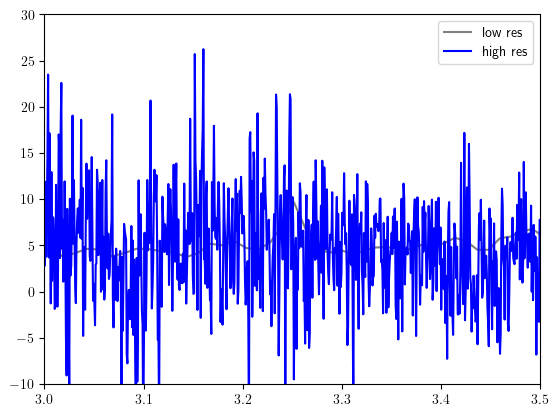

In [83]:
file0 = fits.open('macsj0647-v1_prism-clear_1433_1045.spec.fits') # read in observed jwst prism fits spectrum
spec1d0 = Table(file0[1].data) #get the 'SPEC1D' layer
wave0 = spec1d0['wave'] #in microns (um)
flux0 = 1e-3*spec1d0['flux']*c*(spec1d0['wave']**-2) #uJy to erg/s/cm^2/um; re-scale this to match photometry if you have it
plt.plot(wave0, flux0, color='grey', label='Low res')

plt.plot(wave, flux, color='blue', label='High res')
#plt.xlim(3.5,3.75)
#plt.xlim(2.95,4.3)
plt.xlim(3,3.5)
plt.ylim(-10,30)
plt.legend(fontsize=18)

In [22]:
file[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   40 / length of dimension 1                          
NAXIS2  =                 3619 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    6 / number of table fields                         
VERSION = '0.6.18.dev4+gd736856' / msaexp software version                      
TOMUJY  =                  1.0 / Conversion from pixel values to microJansky    
PROFCEN =    1.358150566836106 / PRF profile center                             
PROFSIG =   1.5251634932112075 / PRF profile sigma                              
PROFSTRT=                   

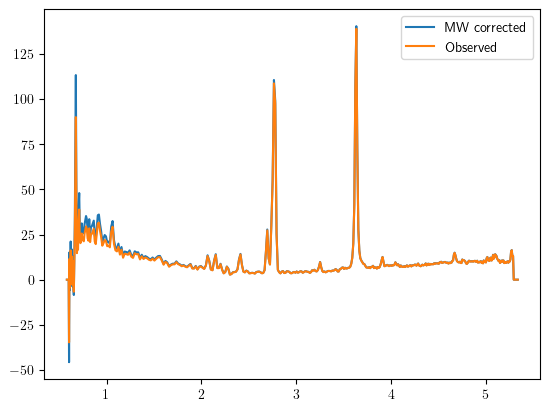

In [19]:
plt.plot(wave0, galactic_ext_corr(wave0, flux0), label='MW corrected')
plt.plot(wave0, flux0, label='Observed')
plt.legend()

In [3]:
%%time

0.0005784799944818405

In [ ]:
los = np.hstack([x[0] - (x[1]-x[0])/2, x[1:] - np.diff(x)/2])
his = np.hstack([x[:-1] + np.diff(x)/2, x[-1] + (x[-1]-x[-2])/2])
binned_y = np.zeros_like(x)

for i in range(len(x)):
    binned_y[i] = F.integrate(los[i],his[i])/(his[i]-los[i]) #use np.trapz and numba instead of integrate to make it fast like Gabe's msaexp func

# Make lmfit model

Make an lmfit model for the observed spectrum.

### Options for left and right continuum:

polynomial - 'polynomial' - i would start with this if you don't yet know anything about the continuum shape

set of splines - 'spline'

extinction (either SMC or Calzetti) corrected power law - 'calz_smc' or 'calz_calz' or 'smc_smc' or 'smc_calz'

### Additional options for right continuum:

blackbody (for emission from dust torus around AGN) - 'calz_bb' or 'smc_bb'

SMC extinction corrected blackbody - 'smc_smcbb' or 'calz_smcbb'

extinction corrected blackbody - 'smc_bb'

I also have FSPS galaxy model for left continuum, but it's waaay too slow, so commented out

### Options for lines:

All narrow lines - broad_lines=[]

Add broad components to some lines - broad_lines=['Ha','Hb']

Interacting galaxy with two sets of narrow lines - test='interacting' (also specify z1, z2, nwid1, nwid2, min_nwid1, min_nwid2, max_nwid1, max_nwid2)


You can also use either Gaussian or Lorentz line profiles - line_model='gauss' or 'lorentz'

### Note:

You can turn on verbose=True, but it takes up a LOT of memory, and the notebook becomes very slow, so use with caution.

In [3]:
class model_spectrum:
    
    def __init__(self, filename='macsj0647-v1_prism-clear_1433_1045.spec.fits',
                 verbose=False, redshift=4.525, line_model='gauss',
                 wobs_range=(2.3,4.8), test='AGN', broad_lines=['Ha'], 
                 cont_model='calz_bb', disp_file='prism', scale_disp=1.3,
                 wid_narrow = 500, wid_broad = 3000, min_wid_narrow=100, max_wid_narrow=1000, min_wid_broad=500, max_wid_broad=5000, 
                 z1=4.52, z2=4.54, nwid1=500, nwid2=500, min_nwid1=100, max_nwid1=1000, min_nwid2=100, max_nwid2=1000):
        
        self.verbose = verbose
        if self.verbose:
            print('Going through model_spectrum __init__')
        
        file = fits.open(filename) #read in jwst prism fits spectrum
        self.spec1d = Table(file[1].data) #get the 'SPEC1D' layer
        sel0 = self.spec1d['flux'] > 0
        self.wave = self.spec1d['wave'][sel0] #microns
        flux = 1e-3*self.spec1d['flux'][sel0]*c*(self.spec1d['wave'][sel0]**-2) #sdss units but in microns instead of Angstroms (1e-17 erg cm^-2 s^-1 um^-1)
        self.flux = galactic_ext_corr(self.wave, flux) #MW extinction corrected spectrum
        self.ferr = 1e-3*self.spec1d['err'][sel0]*c*(self.spec1d['wave'][sel0]**-2) #rescaling flux error by the same factor as flux
        
        self.wobs_range = wobs_range #given range of wavelengths where we want the model to be created
        sel = (self.wave > wobs_range[0]) & (self.wave < wobs_range[1])
        self.wrange = self.wave[sel]
        self.frange = self.flux[sel]
        self.erange = self.ferr[sel]
        
        self.z = redshift #used to set the model wavelength range, and initial guess for single redshift model

        self.wrest_low = 1e4*wobs_range[0]/(1+self.z) #Angstrom; get rest wavelength for given observed wavelength
        self.wrest_high = 1e4*wobs_range[1]/(1+self.z) #Angstrom

        self.prism_res_tab = Table.read(f'jwst_nirspec_{disp_file}_disp.fits') #g395h dispersion curve from jwst documentation
        self.scale_disp = scale_disp #scale factor to improve resolution - Gabe uses 1.3 for point sources - see Christensen, Jakobsen 2023
        
        self.ratios_tab = Table.read('lines_ratios.txt', format='ascii') #.txt file with line ratios to use for close doublets (from grizli utils.get_line_wavelengths)
        
        self.rest_lines = Table.read('lines_list.txt', format='ascii') #.txt file with list of line names and wavelengths (from grizli utils.get_line_wavelengths)
        indices = np.argwhere((self.rest_lines['wavelength(A)'] < self.wrest_high) & (self.rest_lines['wavelength(A)'] > self.wrest_low))
        ls = self.rest_lines['line'][indices] #line names
        ws = self.rest_lines['wavelength(A)'][indices] #rest wavelngths in Angstroms
        lbs = self.rest_lines['label'][indices] #Latex labels for plots
        self.rest_names = [elem[0] for elem in ls] #convert astropy column to list
        self.rest_waves = [elem[0] for elem in ws]
        self.rest_labels = [elem[0] for elem in lbs]
        
        self.test = test #save input options for easy access later
        self.line_model = line_model
        self.cont_model = cont_model
        
        if line_model == 'gauss': #use gaussian profile for lines
            self.mod = self.msa_integ_gauss#self.vw_gauss#
        elif line_model == 'lorentz': #use lorentz profile
            self.mod = self.vw_lorentz
        
        if test == 'AGN': #model with broad lines
            self.model, self.params = self.make_agn_model(broad_lines=broad_lines,
                           cont_model=cont_model,
                           wid_narrow=wid_narrow, min_wid_narrow=min_wid_narrow, max_wid_narrow=max_wid_narrow,
                           wid_broad=wid_broad, min_wid_broad=min_wid_broad, max_wid_broad=max_wid_broad)
            
        elif test == 'interacting': #model with no broad lines
            self.model, self.params = self.make_interacting_model(cont_model=cont_model,
                                   z1=z1, z2=z2,
                                   nwid1=nwid1, min_nwid1=min_nwid1, max_nwid1=max_nwid1,
                                   nwid2=nwid2, min_nwid2=min_nwid2, max_nwid2=max_nwid2)
            
        if self.verbose:
            print('Done with model_spectrum __init__') 
        
    def plot_rest_spec(self, xlims=(1000, 9700), save=False):
    # Plot the rest spectrum and mark expected line positions and wavelengths
    # only for visualization; i have a better version if required

        if self.verbose:
            print('Plotting rest spectrum')

        x = 1e4*self.wave/(1+self.z) #convert to rest frame Angstrom
        y = self.flux*1e-4 #convert to 1e-17 erg cm^-2 s^-1 Angstrom^-1
        cs = ['red','green','blue','goldenrod','violet']
        
        waves_full = np.array(self.rest_lines['wavelength(A)'])
        sel = (waves_full > xlims[0]) & (waves_full < xlims[1])
        
        fig, ax = plt.subplots(figsize=(14,7),dpi=150)
        ax.plot(x, y, color='black')#, linestyle='None', marker='.')
        
        pchip = interpolate.PchipInterpolator(x, y)

        for i in range(len(self.rest_lines[sel])):
            if self.rest_lines[sel]['show'][i] == 0:
                continue
            xtxt = self.rest_lines[sel]['wavelength(A)'][i]
            ytxt = pchip(xtxt)
            ax.vlines(xtxt, ymin=(ytxt)+0.0010, ymax=ytxt+0.0014, linestyle='solid', color='darkviolet')
            llabel = self.rest_lines[sel]['label'][i]
            ax.text(xtxt, ytxt+0.0017, fr'{llabel}', rotation=90, horizontalalignment='center', color='darkviolet')

        plt.xlim(xlims[0], xlims[1])
        plt.ylim(bottom=0)

        ax.minorticks_on()
        plt.xlabel('rest wavelength (A)')
        plt.ylabel(r'$f_\lambda$ (10$^{-17}$ erg/s/cm$^2$/A)')
        
        if save:
            plt.savefig(f'rest_spec_lines_{xlims[0]}_{xlims[1]}.pdf', format='pdf', dpi=200, pad_inches=0, bbox_inches='tight')
        
#         plt.show()

# Getting everything together for lmfit
        
#     def lw_sig_um(self, vw, lam):
#     # Calculate the sigma of line width (in microns) as the sum in quadrature of velocity width and minimum PRISM resolution
#         if self.verbose:
#             print('Convolving PRISM resoultion with given velocity width')

#         pchip = interpolate.PchipInterpolator(self.prism_res_tab['WAVELENGTH'], self.prism_res_tab['R']) #turn the resolution table into a continuous function
#         min_res = self.scale_disp*pchip(lam) #find resolution at given wavelength(s)
#         del_lam = lam/min_res #resolution in microns (assuming res_tab has delta lambdas corresponding to fwhm, not sigma)
#         vw_um = vw*lam/c #convert given real velocity width from km/s to microns
#         lw = np.hypot(vw_um, del_lam) #expected fwhm of observed line for the given real velocity width
#         lw_sigma = lw/2.355 #convert expected fwhm of convolved (line + resolution) to sigma (um)
#         return lw_sigma

#     def vw_lorentz(self, x, ht, mean, vw):
#     # Make a gaussian model with variable velocity width, height, and mean
#         if self.verbose:
#             print('Making Lorentzian line model')

#         lw = self.lw_sig_um(vw, mean) #sigma of line corresponding to given vel width
#         # but i assumed gaussian so converted fwhm to sigma using 2.355; change to 2 for lorentzian
#         sig = lw*2.355/2
#         vw_lorentz_model = ht * (sig**2) / ((x - mean)**2 + sig**2) #A*sig*np.pi = height;
#         #convert fwhm to vw, ht = 2A/fwhm*pi, fwhm = 2 sigma
#         return vw_lorentz_model
    
#     def vw_gauss(self, x, ht, mean, vw):
#     # Make a gaussian model with variable velocity width, height, and mean
#     # vw is FWHM in km/s
#         if self.verbose:
#             print('Making Gaussian line model')
#         lw_sig_um = vw*mean/(2.355*c) #sigma of line corresponding to given vel width; um
#         vw_gauss_model = ht * np.exp(-0.5 * ((x - mean)**2) / (lw_sig_um**2))
#         return vw_gauss_model

    def msa_integ_gauss(self, x, amp, mean, vw): #amp in flux units, lam in um, fwhm of vw in km/s
        disp = self.prism_res_tab
        resolution = np.interp(x, disp['WAVELENGTH'], disp['R'], left=disp['R'][0], right=disp['R'][-1])    
        line = line_func(x.astype(float), resolution.astype(float)*self.scale_disp, mean, line_flux=amp, velocity_sigma=vw/2.355)
        # msaexp function that makes a gaussian line,
        # integrates it over wavelength bins (because that's what the flux in the observed spectrum is - total integrated flux in each wavelength bin),
        # and convolves this with resolution
        return line #an array with 0s everywhere and Gaussian line at given mean

    def get_ratio(self, rat_tab, linename):
    # Get the line ratio from the text file
        if self.verbose:
            print('Getting line ratios from file')

        idx = np.argwhere(linename == self.ratios_tab['line'])
        base = self.ratios_tab['base'][idx][0][0]
        mult = self.ratios_tab['multiplier'][idx][0][0]
        return (base, mult)
    
# Fitting continuum
    
    def fit_extinct_calz(self, x, A_v, norm, beta): #make a Calzetti extinguished power law model
        #x is observed wavelength in microns
        wvrst = x/(1+self.z) #convert to rest wavelength
        wnrst = 1/wvrst #convert to wavenumbers in 1/microns rest-frame
        out = norm*(wnrst**(-beta))*(10**(-0.4*calzatt(wnrst, A_v, 4.05, unit='invum', out=None))) #fit power law and attenuation to rest wavenumbers
        # - should be 10**(-0.4*calzatt)!! calzatt returns Av magnitudes!!
        return out
    def fit_extinct_smc(self, x, A_v, norm, beta): # SMC extinguished power law model
        wvrst = x/(1+self.z) #rest wavelengths
        wnrst = 1/wvrst #convert to wavenumbers in 1/microns rest-frame
        out = norm*(wnrst**(-beta))*smcext.extinguish(wnrst, Av=A_v) #fit power law and attenuation to rest wavenumbers
        return out
    def fit_planck_bb(self, x, temp, norm): #make a Planck blackbody model
        wvrst = x/(1+self.z) #convert to rest-frame microns
        h = 6.6e-27 #erg-s
        c_cm = 3e10 #cm/s
        kB = 1.38e-16 #erg/K
        Blam = norm * ((1+self.z)**-4) * 1e12 * (2*h*(c_cm**2)/(wvrst**5)) / (np.exp(1e4*h*c_cm/(wvrst*kB*temp)) - 1) #fit black body at rest wavelengths
        #incl. cosmological surface brightness dimming
        return Blam #erg/s/cm^2/um/steradian
    def fit_extinct_bb(self, x, temp, norm, A_v): #SMC extinguished blackbody model
        wvrst = x/(1+self.z)
        wnrst = 1/wvrst
        h = 6.6e-27 #erg-s
        c_cm = 3e10 #cm/s
        kB = 1.38e-16 #erg/K
        Blam = norm * ((1+self.z)**-4) * 1e12 * ((2*h*(c_cm**2)/(wvrst**5)) / (np.exp(1e4*h*c_cm/(wvrst*kB*temp)) - 1)) * smcext.extinguish(wnrst, Av=A_v)
        # fit blackbody at rest wavelengths and attenuation at rest wavelengths
        return Blam #erg/s/cm^2/um/steradian

#     def fsps_cont(self, x, norm=1e-20, age=0.01, dust_opt=0.6/1.086):#, dust1_plslope=-1.5):
#         x = 1e4 * x/(1+self.z) #get rest wavelength in angstroms
#         sp = fsps.StellarPopulation(add_neb_emission=False, imf_type=1, dust_type=2, dust1=0.0, dust2=dust_opt)#, dust1_index=dust1_plslope)
#         wave, spec = sp.get_spectrum(tage=age, peraa=True)
#         f = interpolate.CubicSpline(wave, spec, bc_type='natural')
#         spec_out = norm*f(x)
#         return spec_out

    def make_continuum(self, cont_model='calz_bb'):
    # Make a continuum model - combinations of Calzetti, SMC, blackbody, extinguished blackbody
        if self.verbose:
            print(f'Fitting {cont_model} to continuum')
        
        if (cont_model == 'polynomial') or (cont_model == 'spline'):
            cmodel, cparams = self.fit_simple_continuum(self.wrange, self.frange, cont_model=cont_model, nsplines=10)
        
        else:
            lcont, rcont = cont_model.split('_')
            betamin = -3
            betamax = 0

#             if lcont == 'fsps': #SF galaxy
#                 lcmodel = Model(self.fsps_cont, prefix='l_')
#                 lcparams = lcmodel.make_params()
#                 lcparams['l_dust_opt'].set(0.55, min=0)#min=0.1
#                 lcparams['l_age'].set(0.01, min=0)
#                 lcparams['l_norm'].set(1e-17, min=0)
            if lcont == 'calz': #SF galaxy
                lcmodel = Model(self.fit_extinct_calz, prefix='l_')
                lcparams = lcmodel.make_params()
                lcparams['l_A_v'].set(0.8, min=0)#min=0.1
                lcparams['l_beta'].set(-2, min=betamin, max=betamax)
                lcparams['l_norm'].set(1.93, min=0)
            if lcont == 'smc': #AGN
                lcmodel = Model(self.fit_extinct_smc, prefix='l_')
                lcparams = lcmodel.make_params()
                lcparams['l_A_v'].set(0.6, min=0)
                lcparams['l_beta'].set(-2.9, min=betamin, max=betamax)
                lcparams['l_norm'].set(1, min=0)

            if rcont == 'bb': #AGN torus
                rcmodel = Model(self.fit_planck_bb, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_temp'].set(2400, min=0)
                rcparams['r_norm'].set(0.3, min=0)
            if rcont == 'smc': #SF galaxy with attenuation
                rcmodel = Model(self.fit_extinct_smc, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_A_v'].set(5, min=0)
                rcparams['r_beta'].set(-2.9, min=betamin, max=betamax)
                rcparams['r_norm'].set(45, min=0)
            if rcont == 'calz': #SF galaxy with attenuation
                rcmodel = Model(self.fit_extinct_calz, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_A_v'].set(3, min=0)
                rcparams['r_beta'].set(-2, min=betamin, max=betamax)
                rcparams['r_norm'].set(1, min=0)
            if rcont == 'smcbb': #AGN torus with extinction from surrounding material
                rcmodel = Model(self.fit_extinct_bb, prefix='r_')
                rcparams = rcmodel.make_params()
                rcparams['r_temp'].set(2400, min=0)
                rcparams['r_A_v'].set(3, min=0)
                rcparams['r_norm'].set(0.3, min=0)

            cmodel = lcmodel+rcmodel
            cparams = lcparams+rcparams
                
        return(cmodel, cparams)

# The next three functions are to make polynomial or spline continuum models
    def get_cont_level(self, wavelength_array, flux_array, wavelength_position, sample_range=0.2):
    # Get continuum flux at given wavelength position
        if self.verbose:
            print('Estimating continuum flux')

        low = wavelength_position-sample_range/2  #Angstroms
        high = wavelength_position+sample_range/2  #Angstroms
        cont = sigma_clipped_stats(flux_array[np.argwhere((wavelength_array<high)&(wavelength_array>low))],sigma_upper=2)[1] #get the continuum flux, ie, median flux which is < 2 sigma, within the range
        return(cont)

    def masked_continuum(self, ws, fs):#, lwl = [0.65, 2.35, 2.6, 3.2, 3.57, 3.85, 4, 4.6, 5, 5.25], lwh = [0.75, 2.45, 2.81, 3.3, 3.75, 3.96, 4.1, 4.8, 5.18, 5.35]):
    # Return line-masked continuum flux across given observed wavelength range
        if self.verbose:
            print('Masking out lines')

        fmasked = copy.deepcopy(fs)
        for i in range(len(ws)):
            cont_level = self.get_cont_level(ws, fs, ws[i], sample_range=0.2)
            fmasked[i] = cont_level
        return(fmasked)

    def fit_simple_continuum(self, ws, fs, cont_model='polynomial', nsplines=10):
    # Fit the continuum with either a polynomial or spline
        if self.verbose:
            print(f'Fitting {cont_model} to continuum')

        fmasked = self.masked_continuum(ws, fs)
        
        if cont_model == 'polynomial':
            cmodel = PolynomialModel(degree=2)        
        if cont_model == 'spline':
            cmodel = SplineModel(xknots=np.array(np.linspace(self.wrange[0], self.wrange[-1], nsplines)))
        
        cparams = cmodel.guess(fmasked, ws) #automatically guess continuum model parameters

#         for p in cparams: # do not set constraints
#             cparams[p].set(min=cparams[p].value-10, max=cparams[p].value+10)
        
        return(cmodel, cparams)


# Making lmfit model
        
    def make_agn_model(self, broad_lines=['Ha'], cont_model='calz_bb', wid_narrow = 500, wid_broad = 3000,
                   min_wid_narrow=100, max_wid_narrow=1000, min_wid_broad=500, max_wid_broad=5000):
    # Make an lmfit model with broad lines (at the same redshift as narrow lines)
        if self.verbose:
            print('Making AGN model')
    
        cmodel, cparams = self.make_continuum(cont_model=cont_model) #get continuum model and parameters
        
        lines = self.rest_names #get line names and wavelengths in the given observed wavelength range
        rest_waves = self.rest_waves
        
        if len(broad_lines) < 1: #If there are no broad components to add
            broad = False
        else:
            broad = True
#             print(broad)
            if broad_lines[0] == 'all': #if broad components should be added to all lines
                rest_new = [rest_waves[lines.index(elem)] for elem in lines]
                lines += [f'{elem}broad' for elem in lines]
                rest_waves += rest_new
            elif len(set(broad_lines)) == len(broad_lines):                
                lines += [f'{elem}broad' for elem in broad_lines]
                rest_waves += [rest_waves[lines.index(elem)] for elem in broad_lines]
            else:
                seen = set()
                extra = [elem for elem in broad_lines if elem in seen or seen.add(elem)]
                lines += [f'{elem}broad' for elem in set(broad_lines)]
                lines += [f'{elem}extra' for elem in set(extra)]
                rest_waves += [rest_waves[lines.index(elem)] for elem in broad_lines]

        for i, l in enumerate(lines):
            if i == 0:
                lmodel = Model(self.mod, prefix=f'{l}_')
            else:
                lmodel += Model(self.mod, prefix=f'{l}_')
        
#        zmin = self.z-0.01 #0.01 => z can go from 4.52 to 4.54
#        zmax = self.z+0.01
        zmin = self.z-0.02
        zmax = self.z+0.02
        cens = [1e-4*elem*(1+self.z) for elem in rest_waves] #setting line centers in microns
        min_cens = [1e-4*elem*(1+zmin) for elem in rest_waves]
        max_cens = [1e-4*elem*(1+zmax) for elem in rest_waves]
        
        # create parameters for composite line model, but with default values:
        lparams = lmodel.make_params()
        
        model = cmodel + lmodel
        params = cparams + lparams
                
        for p in params:
            l_with_w = p.split('_')[0]
            
            if 'vw' in p:
                if ('broad' not in p) and ('extra' not in p):
                    params[p].set(wid_narrow, min=min_wid_narrow, max=max_wid_narrow) #set min and max for all narrow line velocity fwhms in km/s
#                     if l_with_w != lines[0]:
#                         params[p].set(expr=f'{lines[0]}_vw')
                    # tie all narrow widths to the first one in the list
                    if l_with_w != 'Ha':
                        params[p].set(expr='Ha_vw')
                    # tie all narrow widths to Ha
#                     if l_with_w == 'OIIw3727':
#                         params[p].set(expr='OIIw3729_vw')
#                     if l_with_w == 'CIIIw1906':
#                         params[p].set(expr='CIIIw1908_vw')
#                     if l_with_w == 'SIIIw9068':
#                         params[p].set(expr='SIIIw9531_vw')
#                     if l_with_w == 'OIIIw5007':
#                         params[p].set(expr='OIIIw4959_vw')
                    # tie doublet narrow widths together

                if broad == True:
                    if 'broad' in p:
                        params[p].set(wid_broad, min=min_wid_broad, max=max_wid_broad)
                        #set min for all broad line velocity fwhms in km/s; only use max to set upper limit on hb broad when checking if there is a broad line similar to ha
                        if l_with_w != 'Habroad':
                            params[p].set(expr='Habroad_vw')
                        # tie all broad vw to Habroad vw
#                         if l_with_w != 'OIIIw4959broad':
#                             params[p].set(expr='OIIIw4959broad_vw')
                        # tie all broad vw to OIIIw4959broad vw
#                         if l_with_w != 'Hbbroad':
#                             params[p].set(expr='Hbbroad_vw')
                        # tie all broad vw to Hb
#                         if l_with_w != lines[-1]:
#                            params[p].set(expr=f'{lines[-1]}_vw')
                        # tie all broad widths to the last one in the list; use this if fitting broad lines in region without Ha
#                         if l_with_w == 'OIIIw5007broad':
#                            params[p].set(expr='OIIIw4959broad_vw')
#                       # to fit broad component in Hb at the same width as that from Ha
                        

                    if 'extra' in p:
                        params[p].set(wid_broad, min=min_wid_narrow)#, max=max_wid_broad)
                        
                
            
#             if 'ht' in p:
#                 spl = ['Lya', 'Hb', 'OIIIw4959', 'OIIIw5007', 'Ha', 'Habroad', 'HeIw7065']#, 'Yw2300','Yw3050']
#                 hspl = [65, 20, 35, 110, 106.75, 27.58, 5]#, -5, -5]
# #                 lhspl = [40, 10, 25, 80, 70, 10, 3]
# #                 hhspl = [100, 30, 50, 120, 130, 60, 8]
#                 if l_with_w in spl:
#                     ht = hspl[spl.index(l_with_w)]
# #                     min_ht = lhspl[spl.index(l_with_w)]
# #                     max_ht = hhspl[spl.index(l_with_w)]
#                 else:
#                     ht = 5
# #                     min_ht = 0
# #                     max_ht = 15
                    
#                 params[p].set(ht)
#                 if l_with_w.startswith('Y'):
#                     params[p].set(max=0)
#                 else:
#                     params[p].set(min=0)
# #                 if l_with_w == 'Hg':
# #                     params[p].set(9.043, max = 12.054, min = 8.2)
# #                 params[p].set(hts[lines.index(l_with_w)], min=min_hts[lines.index(l_with_w)], max=max_hts[lines.index(l_with_w)])
#                 # does not include the numbers in combined line ratios (e.g.Ha+NII+SII+He) - should i include these?
#                 if l_with_w in self.ratios_tab['line']:
#                     base, mult = self.get_ratio(self.ratios_tab, l_with_w)
#                     if base in lines:
#                         params[f'{p}'].set(expr=f'{base}_ht*{mult}')
#                 #if both lines are in the observed wavelength range, then set their height ratio
#                 if broad == True:
#                     if ('broad' in p) or ('extra' in p):
#                         if 'broad' in p:
#                             be = 'broad'
#                         elif 'extra' in p:
#                             be = 'extra'
#                         nwl = l_with_w.replace(be,'')
# #                         if (broad_lines[0] == 'all') and (l_with_w != 'Habroad'): #if all lines need broad components, the fraction of broad/narrow height must be specified to reduce the number of free parameters
# #                             params[p].set(expr=f'{nwl}_ht*Habroad_ht/Ha_ht')
#                         if len(broad_lines) > 1: #if there are a few named lines that need broad components
#                             if nwl in self.ratios_tab['line']:
#                                 base, mult = self.get_ratio(self.ratios_tab, nwl)
#                                 if f'{base}{be}' in lines:
#                                     params[p].set(expr=f'{base}{be}_ht*{mult}') #if both base and line need a broad component, set the broad height ratio
            if 'amp' in p:
                spl = ['Lya', 'Hb', 'OIIIw4959', 'OIIIw5007', 'Ha', 'Habroad', 'HeIw6678']#, 'Yw2300','Yw3050']
#                hspl = [0.8, 0.6, 1, 3.3, 2.4, 1.5, 0.03]#, -5, -5]
                hspl = [0.8, 0.6, 1, 3.3, 0.5, 0.1, 0.03]
#                 lhspl = [40, 10, 25, 80, 70, 10, 3]
#                 hhspl = [100, 30, 50, 120, 130, 60, 8]
                if l_with_w in spl:
                    ht = hspl[spl.index(l_with_w)]
#                     min_ht = lhspl[spl.index(l_with_w)]
#                     max_ht = hhspl[spl.index(l_with_w)]
                else:
                    ht = 0.05
#                     min_ht = 0
#                     max_ht = 15
                    
                params[p].set(ht,min=0)
#                 if l_with_w == 'Hg':
#                     params[p].set(9.043, max = 12.054, min = 8.2)
#                 params[p].set(hts[lines.index(l_with_w)], min=min_hts[lines.index(l_with_w)], max=max_hts[lines.index(l_with_w)])
                # does not include the numbers in combined line ratios (e.g.Ha+NII+SII+He) - should i include these?
                if l_with_w in self.ratios_tab['line']:
                    base, mult = self.get_ratio(self.ratios_tab, l_with_w)
                    if base in lines:
                        params[f'{p}'].set(expr=f'{base}_amp*{mult}')
                #if both lines are in the observed wavelength range, then set their height ratio
                if broad == True:
                    if ('broad' in p) or ('extra' in p):
                        if 'broad' in p:
                            be = 'broad'
                        elif 'extra' in p:
                            be = 'extra'
                        nwl = l_with_w.replace(be,'')
#                         if (broad_lines[0] == 'all') and (l_with_w != 'Habroad'): #if all lines need broad components, the fraction of broad/narrow height must be specified to reduce the number of free parameters
#                             params[p].set(expr=f'{nwl}_ht*Habroad_ht/Ha_ht')
                        if len(broad_lines) > 1: #if there are a few named lines that need broad components
                            if nwl in self.ratios_tab['line']:
                                base, mult = self.get_ratio(self.ratios_tab, nwl)
                                if f'{base}{be}' in lines:
                                    params[p].set(expr=f'{base}{be}_amp*{mult}') #if both base and line need a broad component, set the broad height ratio            
            
            if 'mean' in p:
                if 'extra' in p:
                    mmin = min_cens[lines.index(l_with_w)]-0.05 #redshifted component 'extra'
                    mmax = max_cens[lines.index(l_with_w)]+0.05
                else:
                    mmin = min_cens[lines.index(l_with_w)]
                    mmax = max_cens[lines.index(l_with_w)]
                    
                nom_cen = cens[lines.index(l_with_w)]
                params[p].set(nom_cen, min=mmin, max=mmax)
#                 if 'broad' not in p:
#                     if (nom_cen < 3) and (l_with_w != 'Hb'): #to fit different zs on left and right side
#                         hbrest = rest_waves[lines.index('Hb')]
#                         params[p].set(expr=f'Hb_mean*{rest_waves[lines.index(l_with_w)]}/{hbrest}') #tie left wavelengths to Hb
#                     if (nom_cen >= 3) and (l_with_w != 'Ha'):
#                         harest = rest_waves[lines.index('Ha')]
#                         params[p].set(expr=f'Ha_mean*{rest_waves[lines.index(l_with_w)]}/{harest}') #tie right wavelengths to Ha

#                 if ('broad' not in p) and ('extra' not in p) and (l_with_w != lines[0]):
#                     params[p].set(expr=f'{lines[0]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[0]}')
                # tie all narrow line wavelengths to the first one in the list - is it okay if first one is Lya? inaccurate z??
                if ('broad' not in p) and ('extra' not in p) and (l_with_w != 'Ha'):
                    params[p].set(expr=f'Ha_mean*{rest_waves[lines.index(l_with_w)]}/6564.697')
                # tie all narrow line means to Ha
#                 if ('broad' not in p) and ('extra' not in p) and (l_with_w != 'OIIIw4959'):
#                     params[p].set(expr=f'OIIIw4959_mean*{rest_waves[lines.index(l_with_w)]}/4960.295')
                # tie all narrow line wavelengths to OIIIw4959

                if broad == True:
                    if 'broad' in p:
                        nwp = p.replace('broad','')
                        params[p].set(expr=str(nwp))
                   # tie all broad line wavelengths to corresponding narrow line wavelengths - because it looks like ha broad and narrow have no offset
#                     if ('broad' in p) and (l_with_w != lines[-1]) and (l_with_w != 'Hbbroad'):
#                         params[p].set(expr=f'{lines[-1]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[-1]}') #assuming last one in the list is a broad line
                   # tie all broad wavelengths together; don't tie them to corresponding narrow wavelengths to allow for narrow-broad offset; eg: from outflow
#                     if ('broad' in p) and (l_with_w != 'Habroad'):
#                         params[p].set(expr=f'Habroad_mean*{rest_waves[lines.index(l_with_w)]}/6564.697')
                   # tie all broad line means to Habroad
#                     if ('broad' in p) and (l_with_w == 'OIIIw4959broad'):
#                         params[p].set(expr=f'OIIIw5007broad_mean*{rest_waves[lines.index(l_with_w)]}/5008.239')
                   # tie broad oiiis together, but let broad Hb be free
#                     if ('extra' in p) and (l_with_w == 'OIIIw4959extra'):
#                         params[p].set(expr=f'OIIIw5007extra_mean*{rest_waves[lines.index(l_with_w)]}/5008.239')
                   # tie extra component mean to narrow mean

        return(model, params) #return the model and parameters

    def make_interacting_model(self, cont_model='calz_bb', z1=4.528, z2=4.537, nwid1=500, nwid2=500, min_nwid1=100, max_nwid1=1000, min_nwid2=100, max_nwid2=1000):
    # Make an lmfit model with two narrow components at different redshifts and velocity widths - increase max limit on vw??
        if self.verbose:
            print('Making interacting galaxy model')
        
        cmodel, cparams = self.make_continuum(cont_model=cont_model)
    
        lines = self.rest_names
        rest_waves = self.rest_waves
        
        lines1 = [f'One{elem}' for elem in lines]
        lines2 = [f'Two{elem}' for elem in lines]
        lines = lines1+lines2
        rest_waves += rest_waves
        zs = np.hstack((np.full(len(lines1),z1), np.full(len(lines2),z2)))

#         model = PolynomialModel(degree=2) #continuum #degree 1 => y = mx + c => c0 is the y intercept and c1 is the slope

        for i, l in enumerate(lines):
            if i == 0:
                lmodel = Model(self.mod, prefix=f'{l}_')
            else:
                lmodel += Model(self.mod, prefix=f'{l}_')

        cens = 1e-4*np.array(rest_waves)*(1+zs)
        min_cens = [elem-0.01 for elem in cens]
        max_cens = [elem+0.01 for elem in cens]

        # create parameters for composite model, but with default values:
        lparams = lmodel.make_params()
        
        model = cmodel + lmodel
        params = cparams + lparams

        for p in params:
            l_with_w = p.split('_')[0]
            if 'vw' in p:
                if 'One' in p:
                    params[p].set(nwid1, min=min_nwid1, max=max_nwid1) #set all left line velocity fwhms in km/s
                    if l_with_w != lines1[0]:
                        params[p].set(expr=f'{lines1[0]}_vw') #tie all left fwhms to left Ha width
                if 'Two' in p:
                    params[p].set(nwid2, min=min_nwid2, max=max_nwid2) #set all right line velocity fwhms in km/s
                    if l_with_w != lines2[0]:
                        params[p].set(expr=f'{lines2[0]}_vw') #tie all right fwhms to right Ha width

#             if 'ht' in p:
#                 nonuml = l_with_w.replace('Two','')
#                 nonuml = nonuml.replace('One','')

#                 spl = ['Lya', 'Hb', 'OIIIw4959', 'OIIIw5007', 'Ha']
#                 hspl = [30, 5, 15, 30, 60]
# #                 lhspl = [10, 1, 1, 10, 10]
# #                 hhspl = [80, 30, 40, 90, 90]
#                 if nonuml in spl:
#                     ht = hspl[spl.index(nonuml)]
# #                     min_ht = lhspl[spl.index(nonuml)]
# #                     max_ht = hhspl[spl.index(nonuml)]
#                 else:
#                     ht = 5
# #                     min_ht = 0.01
# #                     max_ht = 15

#                 params[p].set(ht, min=0)#, max=max_ht)

#                 if nonuml in self.ratios_tab['line']:
#                     base, mult = self.get_ratio(self.ratios_tab, nonuml)
#                     if 'One' in p:
#                         numbase = f'One{base}'
#                         if numbase in lines:
#                             params[p].set(expr=f'{numbase}_ht*{mult}')
#                     if 'Two' in p:
#                         numbase = f'Two{base}'
#                         if numbase in lines:
#                             params[p].set(expr=f'{numbase}_ht*{mult}')
            if 'amp' in p:
                nonuml = l_with_w.replace('Two','')
                nonuml = nonuml.replace('One','')

                spl = ['Lya', 'Hb', 'OIIIw4959', 'OIIIw5007', 'Ha']
                hspl = [0.30, 0.05, 0.15, 0.30, 0.60]
#                 lhspl = [10, 1, 1, 10, 10]
#                 hhspl = [80, 30, 40, 90, 90]
                if nonuml in spl:
                    ht = hspl[spl.index(nonuml)]
#                     min_ht = lhspl[spl.index(nonuml)]
#                     max_ht = hhspl[spl.index(nonuml)]
                else:
                    ht = 0.05
#                     min_ht = 0.01
#                     max_ht = 15

                params[p].set(ht, min=0)#, max=max_ht)

                if nonuml in self.ratios_tab['line']:
                    base, mult = self.get_ratio(self.ratios_tab, nonuml)
                    if 'One' in p:
                        numbase = f'One{base}'
                        if numbase in lines:
                            params[p].set(expr=f'{numbase}_amp*{mult}')
                    if 'Two' in p:
                        numbase = f'Two{base}'
                        if numbase in lines:
                            params[p].set(expr=f'{numbase}_amp*{mult}')


            if 'mean' in p:
                params[p].set(cens[lines.index(l_with_w)], min=min_cens[lines.index(l_with_w)], max=max_cens[lines.index(l_with_w)])
                if (l_with_w != lines1[0]) and ('One' in p):
                    params[p].set(expr=f'{lines1[0]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[0]}')
                if (l_with_w != lines2[0]) and ('Two' in p):
                    params[p].set(expr=f'{lines2[0]}_mean*{rest_waves[lines.index(l_with_w)]}/{rest_waves[0]}')

        return(model, params)

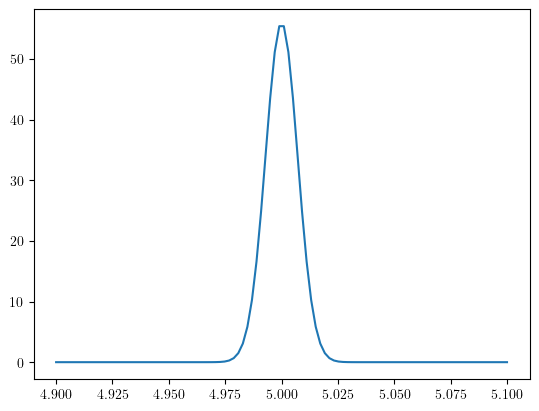

In [107]:
x = np.linspace(4.9,5.1,100)
y = spec.msa_integ_gauss(x, 1, 5, 1000)
plt.plot(x, y)

In [109]:
sig = 5*1000/(2.355*c)
ht = 1/(np.sqrt(2*np.pi)*sig)
sig, ht

(0.007077140835102618, 56.370544220722444)

In [102]:
help(spec.msa_integ_gauss)

Help on method msa_integ_gauss in module __main__:

msa_integ_gauss(x, amp, mean, vw) method of __main__.model_spectrum instance



In [4]:
spec = model_spectrum(filename='macs0647_highres_1045.v1.spec.fits', wobs_range=(3.5,3.75),
                      disp_file='g395h', scale_disp=1,
                      wid_narrow = 100, min_wid_narrow=1, max_wid_narrow=1000,
                      wid_broad = 6000, min_wid_broad=1000, max_wid_broad=10000,
                      broad_lines=[], cont_model='polynomial')
# np.where(spec.model.eval(spec.params, x=spec.wrange) < 0)
# xarr = np.linspace(1.8,2.6,100)
init = spec.model.eval(params=spec.params, x=spec.wrange)
spec.params

name,value,initial value,min,max,vary,expression
c0,-564.711094,None,-inf,inf,True,
c1,317.228479,None,-inf,inf,True,
c2,-44.0051422,None,-inf,inf,True,
NIIw6549_amp,0.05000000,None,0.00000000,inf,True,
NIIw6549_mean,3.61879765,None,3.60569793,3.63189737,False,Ha_mean*6549.86/6564.697
NIIw6549_vw,100.000000,None,1.00000000,1000.00000,False,Ha_vw
Ha_amp,0.50000000,None,0.00000000,inf,True,
Ha_mean,3.62699509,None,3.61386570,3.64012449,True,
Ha_vw,100.000000,None,1.00000000,1000.00000,True,
NIIw6585_amp,0.15000000,None,0.00000000,inf,False,NIIw6549_amp*3.0


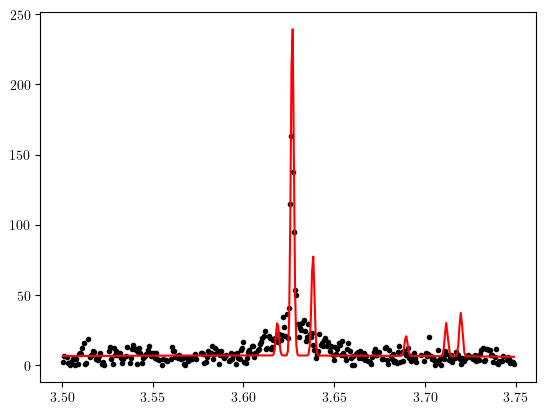

In [5]:
# Check whether the model approximately looks like the observed spectrum.
# If not, modify the initial parameters until there is a decent match

plt.plot(spec.wrange, spec.frange, color='black', ls='None', marker='.')
plt.plot(spec.wrange, init, color='red')

In [46]:
spec = model_spectrum(wobs_range=(0.5,5.5), scale_disp=1.3, wid_broad = 6000, min_wid_broad=4005, max_wid_broad=4641,
                      broad_lines=['Ha'], cont_model='polynomial')
# np.where(spec.model.eval(spec.params, x=spec.wrange) < 0)
# xarr = np.linspace(1.8,2.6,100)
init = spec.model.eval(params=spec.params, x=spec.wrange)
spec.params#.lw_sig_um(300, 9071)*2.335*c/9071

name,value,initial value,min,max,vary,expression
c0,34.6887453,None,-inf,inf,True,
c1,-17.7813788,None,-inf,inf,True,
c2,2.62484851,None,-inf,inf,True,
Lya_amp,0.80000000,None,0.00000000,inf,True,
Lya_mean,0.67235928,None,0.67114388,0.67357468,False,Ha_mean*1215.4/6564.697
Lya_vw,500.000000,None,100.000000,1000.00000,False,Ha_vw
Xw1280_amp,0.05000000,None,0.00000000,inf,True,
Xw1280_mean,0.70809600,None,0.70681600,0.70937600,False,Ha_mean*1280.0/6564.697
Xw1280_vw,500.000000,None,100.000000,1000.00000,False,Ha_vw
CIIw1335_amp,0.05000000,None,0.00000000,inf,True,


# Fit lmfit model

Fit the model created above to the observed spectrum.

Option to re-scale JWST uncertainties, assuming that the model is a good approximation - probably can skip this if using MCMC later

In [6]:
class fit_spectrum(model_spectrum):
# Fits the model produced by model_spectrum
    def __init__(self, filename='macsj0647-v1_prism-clear_1433_1045.spec.fits',
                 redshift=4.525, wobs_range=(2.3, 4.8),
                 line_model='gauss', test='AGN', broad_lines=['Ha'],
                 cont_model='polynomial', disp_file='prism', scale_disp=1.3,
                 wid_narrow = 500, min_wid_narrow=100, max_wid_narrow=1000,
                 wid_broad = 3500, min_wid_broad=500, max_wid_broad=5000,
                 z1=4.52, z2=4.54,
                 nwid1=500, min_nwid1=100, max_nwid1=1000,
                 nwid2=500, min_nwid2=100, max_nwid2=1000,
                 wranges_list=[(0.6,1.1),(2,2.5),(2.6,2.85),(3.2,3.5),(3.55,3.72),(3.8,4.1),(4.6,5.3)], #for zoom-in plots
                 scale_errors=False, save=True, verbose=False):
        
        self.verbose = verbose

        if self.verbose:
            print('Going through fit __init__')
        
        super().__init__(filename=filename, verbose=verbose, redshift=redshift, wobs_range=wobs_range,
                         line_model=line_model, test=test, broad_lines=broad_lines, 
                         cont_model=cont_model, disp_file=disp_file, scale_disp=scale_disp,
                         wid_narrow=wid_narrow, min_wid_narrow=min_wid_narrow, max_wid_narrow=max_wid_narrow,
                         wid_broad=wid_broad, min_wid_broad=min_wid_broad, max_wid_broad=max_wid_broad,
                         z1=z1, z2=z2,
                         nwid1=nwid1, min_nwid1=min_nwid1, max_nwid1=max_nwid1,
                         nwid2=nwid2, min_nwid2=min_nwid2, max_nwid2=max_nwid2) #inherit all attributes and methods from model_spec

        self.wranges_list = self.get_relevant_zoom(wranges_list)
        
        self.result, self.uscale = self.fit_model(scale_errors=scale_errors) #Nelder fit result and uncertainty scaling
                        
        if save:
            broadls = ''
            if len(broad_lines) > 0:
                self.broadls = '_'.join(broad_lines)
            else:
                self.broadls = ''
            self.save = f'{test}_{cont_model}_{self.broadls}_{wobs_range[0]}_{wobs_range[1]}_{int(scale_errors)}'
        else:
            self.save = 'None'
        
        self.fit_plot = self.plot_fit_spec(self.result, scaling=self.uscale) #only plot Nelder fit to spectrum
        
        if save:
            self.save_self()
            
        if self.verbose:
            print('Done with fit __init__')

    def save_self(self):
        if self.verbose:
            print('Saving self to file')

        file = open(f'emcee_output/{self.save}_self','wb')
        dill.dump(self, file)
        file.close()
              
    def get_relevant_zoom(self, wranges_list):
    # Get only the zoom-in plot ranges within given observed wavelength range
        if self.verbose:
            print('Getting relevant zoom-in plot ranges')

        new_wranges = [elem for elem in wranges_list if (elem[0] > self.wobs_range[0]) & (elem[1] < self.wobs_range[1])]        
        return(new_wranges)

# lmfit fitting

    def fit_model(self, scale_errors=True):
        if self.verbose:
            print('Fitting with lmfit')
        
        def scaled_result(res):
            if self.verbose:
                print('Scaling uncertainties')

        # Scale the (incorrect) JWST uncertainties so that reduced chisquared is 1
            def calc_uncertainty_scale(spec, spl, method='bfgs', order=3, init=(1, 3), **kwargs):
            # Function from Gabe's msaexp, slightly modified
                if self.verbose:
                    print('Calculating uncertainty scaling')

                ok = (spec['err'] > 0) & (spec['flux'] != 0) & np.isfinite(spec['err']+spec['flux'])

                if init is not None:
                    err = init[0]*spec['err']
                    err = np.sqrt(err**2 + (0.02*spec['flux'])**2)
                    _Ax = spl/err
                    _yx = spec['flux']/err
                    _x = np.linalg.lstsq(_Ax[:,ok].T, _yx[ok], rcond=None)
                    _model = spl.T.dot(_x[0])
                    ok &= np.abs((spec['flux']-_model)/err) < init[1]

                def objfun_scale_uncertainties(c):

                    err = 10**np.polyval(c, spec['wave'])*spec['err']
                    err = np.sqrt(err**2 + (0.02*spec['flux'])**2)

                    _Ax = spl/err
                    _yx = spec['flux']/err
                    _x = np.linalg.lstsq(_Ax[:,ok].T, _yx[ok], rcond=None)
                    _model = spl.T.dot(_x[0])

                    lnp = norm.logpdf((spec['flux']-_model)[ok],
                                      loc=_model[ok]*0.,
                                      scale=err[ok]).sum()    
                    return -lnp/2.

                c0 = np.zeros(order+1)

                res = minimize(objfun_scale_uncertainties, c0, method=method)

                return spec, 10**np.polyval(res.x, spec['wave']), res

            def get_uscale(wave, flux, ferr, temps):
            # Format input correctly for calc_uncertainty_scale, and get the scale factor array to multiply with uncertainty array
                if self.verbose:
                    print('Getting scaled uncertainties')

                tab = Table()
                tab.add_columns([wave, flux, ferr])#, names = ['wave','flux','err'])
                _,scl,_ = calc_uncertainty_scale(tab, temps)
                return scl
            
            xarr = np.linspace(self.wrange.min(),self.wrange.max(),len(self.wrange))
            comps = res.eval_components(x=xarr)
            comp_list = list(comps.items())
            comp_arrs = []
            for elem in comp_list:
                comp_arrs.append(elem[1])
            temps = np.array(comp_arrs)
            uscale = get_uscale(self.wrange, self.frange, self.erange, temps)
            
            res_scaled = self.model.fit(self.frange, self.params, x=self.wrange, weights=1/(self.erange*uscale))
            return (uscale, res_scaled)

        if self.verbose:
            print('Started lmfit fitting')
        
#         def objective(params, x, data, err):
#             mod = spec.model.eval(params=params, x=x)
#             return(mod-data)/err

#         result = lmfit.minimize(objective, self.params, args=(np.array(self.wrange).astype(float), np.array(self.frange).astype(float), np.array(self.erange).astype(float)), method='nelder')
        
        result = self.model.fit(self.frange, self.params, x=self.wrange, weights=1/self.erange)#, nan_policy='omit')#, method='Nelder') #, fit_kws={'ftol': 1e-07}
        # default fit tolerance is 1e-8; setting to 1e-7 hoping it will quit fitting faster
        if self.verbose:
            print('Finished lmfit fitting')

        if scale_errors:
            scaling, result = scaled_result(result)
        else:
            scaling = 1 #doubling JWST errors - why 2? idk, just random - from Darach
#         print(result.fit_report())
        
        return(result, scaling)

# Plotting

    def zoom_in_plots(self, dill_file_name, xarr, yarr, scl):
    # Make zoomed in plots from given dilled figure and wavelength ranges - check why y axis does not go down low enough to see NII and SII components in Ha complex fit
        if self.verbose:
            print('Making zoom-in plots')

        nfigs = len(self.wranges_list)
        for i in range(nfigs):
            axs = dill.load(open(dill_file_name,'rb'))
            wlow, whigh = self.wranges_list[i]
            
            axs[0].set_xlim(wlow,whigh)
            
            args = np.where((self.wrange > wlow) & (self.wrange < whigh)) #len = len(data)
            args_smooth = np.where((xarr > wlow) & (xarr < whigh)) #len = len(xarr) = 10*len(data)
            
            if type(scl) == int:
                scl = scl
            else:
                scl = np.max(scl[args])
            yhigh = max(np.max(yarr[args_smooth]), np.max(self.frange[args])+np.max(self.erange[args])*scl) #use the higher of fit and data+error for plot range
            
            axs[0].set_ylabel(r'$f_\lambda$', fontsize=18)
            axs[0].set_ylim(-1,yhigh)
            axs[0].get_legend().remove()
            
            if self.save is not None:
                plt.savefig(f'emcee_output/{self.save}_zoom_{wlow}_{whigh}.pdf', format='pdf', dpi=200, pad_inches=0, bbox_inches='tight')
            plt.show()
    

    def plot_fit_spec(self, res, scaling=1):
    # Plot the fit spectrum with all its components
        if self.verbose:
            print('Making fit plot')

        xarr = np.linspace(self.wrange.min(),self.wrange.max(),len(self.wrange)*10)
        yarr = res.eval(x=xarr)
        comps = res.eval_components(x=xarr)
        ymod = res.eval(x=self.wrange)
        
        fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]}, figsize=(10,7), dpi=150)
        fig.subplots_adjust(hspace=0)
        
        ydat = self.frange
        yerror = self.erange*scaling
        axs[0].step(self.wrange, ydat, where='mid', color='blue', label='Data')#, linestyle='None', marker='.'
        axs[0].errorbar(self.wrange, ydat, yerr=yerror, color='blue', linestyle='None')
        axs[0].plot(xarr, yarr, linestyle='dashed', c='black', label='Total fit')   

        for comp in comps:
            l = comp.split('_')[0]
            if l in self.rest_names:
                if 'broad' in l:
                    arg = self.rest_names.index(l.replace('broad',''))
                    wlen = self.rest_waves[arg]
                    label = fr'{self.rest_labels[arg]}$_\mathrm{{broad}}$\,{wlen:.2f}'
                elif 'extra' in l:
                    arg = self.rest_names.index(l.replace('extra',''))
                    wlen = self.rest_waves[arg]
                    label = fr'{self.rest_labels[arg]}$_\mathrm{{extra}}$\,{wlen:.2f}'
                else:
                    arg = self.rest_names.index(l)
                    wlen = self.rest_waves[arg]
                    label = fr'{self.rest_labels[arg]}\,{wlen:.2f}'
            elif 'One' in l:
#                 print(l)
                arg = self.rest_names.index(l.replace('One',''))
                wlen = self.rest_waves[arg]
                label = fr'{self.rest_labels[arg]}$_1${wlen:.2f}'
#                 print(label)
            elif 'Two' in l:
                arg = self.rest_names.index(l.replace('Two',''))
                wlen = self.rest_waves[arg]
                label = fr'{self.rest_labels[arg]}$_2${wlen:.2f}'

            elif l == 'l':
                label = r'Continuum$_\mathrm{UV}$'
            elif l == 'r':
                label = r'Continuum$_\mathrm{NIR}$'
            else:
                label = l
            axs[0].plot(xarr, comps[comp], label=label)

        axs[0].set_ylabel(r'$f_\lambda$ (10$^{-17}$ erg/s/cm$^2$/$\rm\mu$m)', fontsize=18)
#         axs[0].set_ylim(bottom=-0)
        axs[0].tick_params(axis='y', labelsize=18)
        axs[0].yaxis.set_major_locator(MaxNLocator(prune='lower'))

#         axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.675), fancybox=True, ncol=6)
        axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fancybox=True, ncol=6)
        
        yresid = ydat-ymod
#         axs[1].step(self.wrange, yresid, where='mid', color='skyblue')
#         axs[1].errorbar(self.wrange, yresid, yerr=yerror, ls='', color='skyblue')
#         axs[1].axhline(0,ls='--', color='grey')
#         axs[1].set_ylim(-10,10)
#         axs[1].set_ylabel('Residual', fontsize=18)#\n(Data $-$ Model)

        ychi = yresid/yerror
        axs[1].step(self.wrange, ychi, where='mid', color='skyblue')
        axs[1].errorbar(self.wrange, ychi, yerr=np.ones_like(yerror),ls='', color='skyblue')
        axs[1].axhline(0,ls='--', color='grey')
        axs[1].set_ylabel(r'$\chi$', fontsize=18)
        axs[1].tick_params(axis='both', labelsize=18)

        plt.xlabel(r'$\lambda_\mathrm{obs}\,$($\rm\mu$m)', fontsize=18)
        
        if self.save is not None:
            plt.savefig(f'emcee_output/{self.save}_fig.pdf', format='pdf', dpi=200, pad_inches=0, bbox_inches='tight')

#         file = open(f'plots/{self.save}_dill','wb')
#         dill.dump(axs, file)
#         self.zoom_in_plots(f'plots/{self.save}_dill', xarr, yarr, scaling)
#         file.close()
        
        return(fig)

# Test fit function

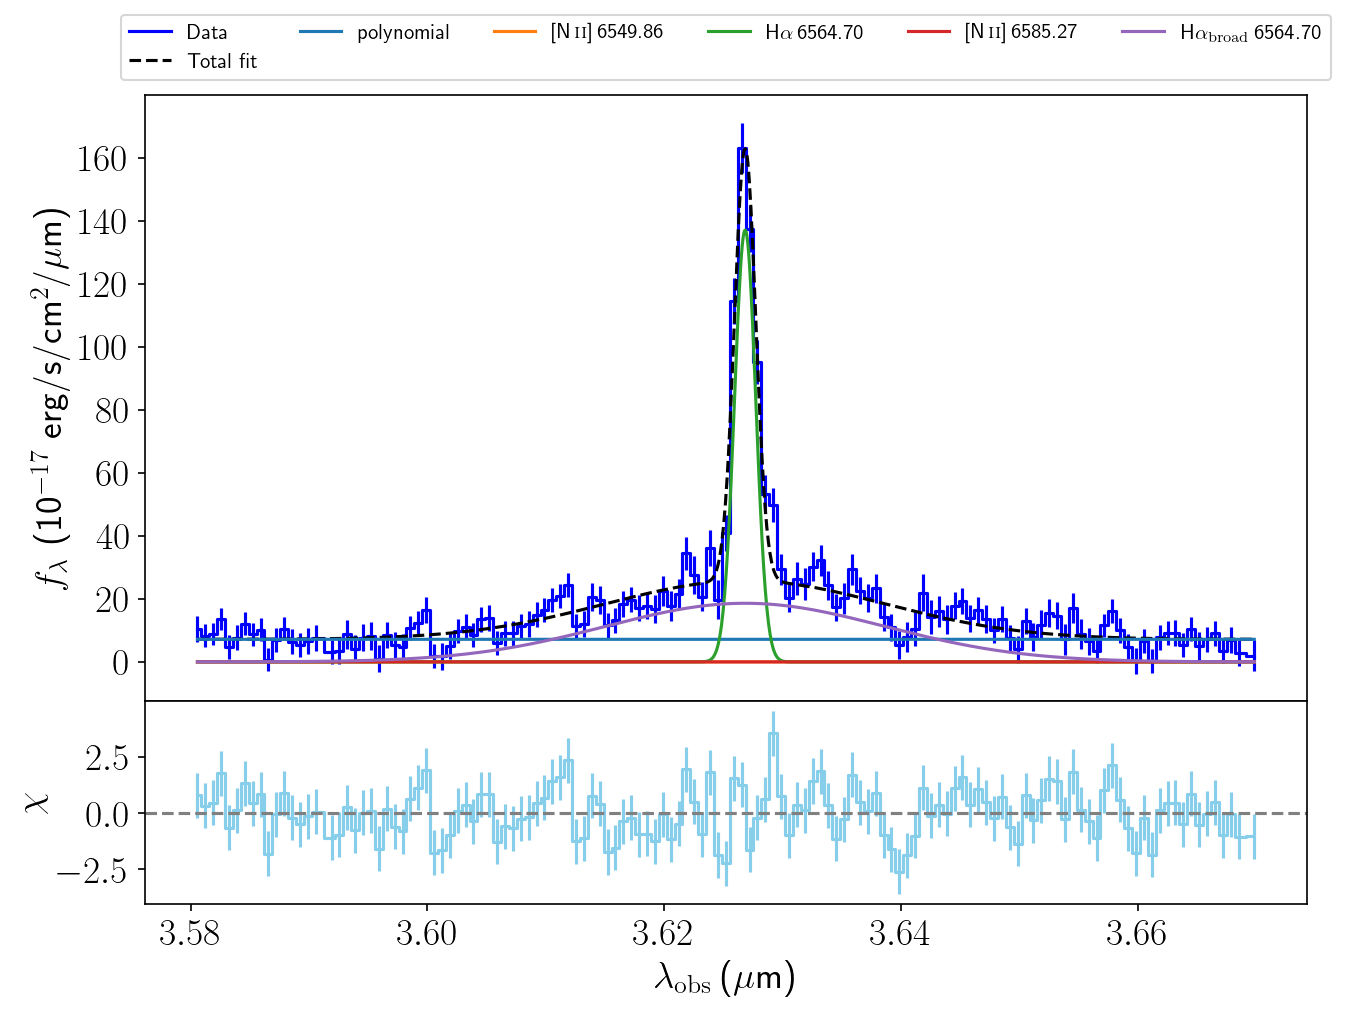

In [8]:
test = fit_spectrum(filename='macs0647_highres_1045.v1.spec.fits', wobs_range=(3.58,3.67),
                    scale_disp=1, disp_file='g395h',
                    wid_narrow = 100, min_wid_narrow=1, max_wid_narrow=1000,
                    wid_broad = 4500, min_wid_broad=1000, max_wid_broad=10000,
                    broad_lines=['Ha'], cont_model='polynomial',
                    scale_errors=False, verbose=False, save=True)

In [115]:
pchip = interpolate.PchipInterpolator(spec.prism_res_tab['WAVELENGTH'], spec.prism_res_tab['R']) #turn the resolution table into a continuous function
min_res = spec.scale_disp*pchip(ps['Ha_mean'].value) #find resolution at given wavelength(s)
del_lam = ps['Ha_mean'].value/min_res #resolution in microns (assuming res_tab has delta lambdas corresponding to fwhm, not sigma)
vw_um = ps['Ha_vw'].value*ps['Ha_mean'].value/c #convert given real velocity width from km/s to microns
lw = np.hypot(vw_um, del_lam) #expected fwhm of observed line for the given real velocity width
lw_sigma = lw/2.355

#sig = ps['Ha_mean'].value*ps['Ha_vw'].value/(2.355*c)
ht = ps['Ha_amp'].value/(np.sqrt(2*np.pi)*lw_sigma)
lw_sigma, ht

(0.0009005473763206015, 137.34711121952495)

In [116]:
min_res = spec.scale_disp*pchip(ps['Habroad_mean'].value) #find resolution at given wavelength(s)
del_lam = ps['Habroad_mean'].value/min_res #resolution in microns (assuming res_tab has delta lambdas corresponding to fwhm, not sigma)
vw_um = ps['Habroad_vw'].value*ps['Habroad_mean'].value/c #convert given real velocity width from km/s to microns
lw = np.hypot(vw_um, del_lam) #expected fwhm of observed line for the given real velocity width
lw_sigma = lw/2.355

#sig = ps['Habroad_mean'].value*ps['Habroad_vw'].value/(2.355*c)
ht = ps['Habroad_amp'].value/(np.sqrt(2*np.pi)*lw_sigma)
lw_sigma, ht

(0.012083232721159092, 18.63410642908579)

In [9]:
test.result

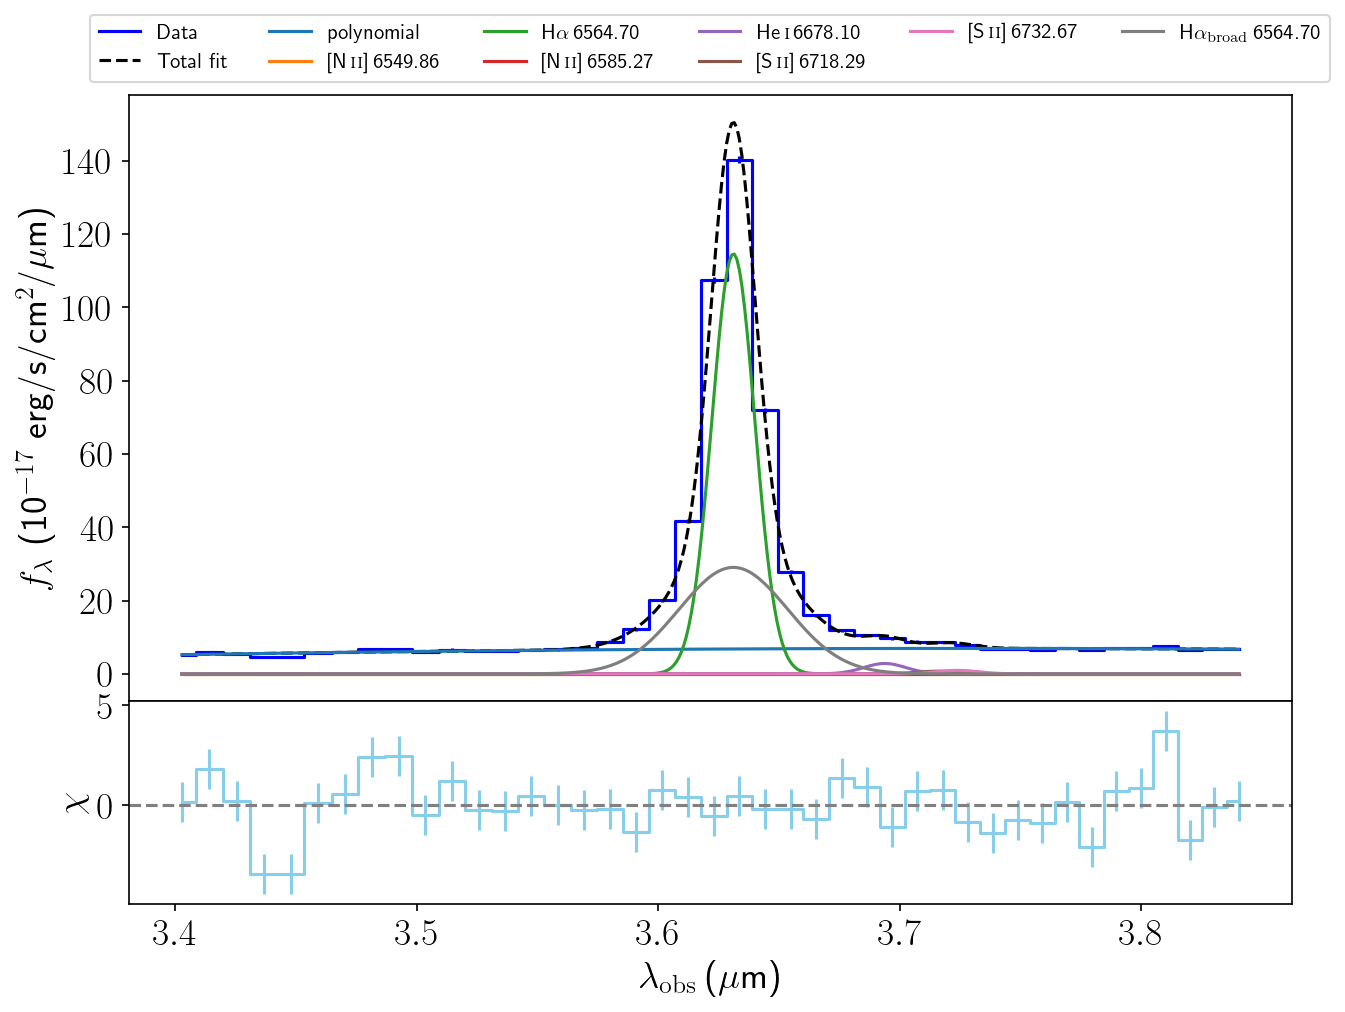

In [88]:
test = fit_spectrum(wobs_range=(3.4,3.85), scale_disp=1.3,
                    wid_narrow = 700, min_wid_narrow=100, max_wid_narrow=10000,
                    wid_broad = 4500, min_wid_broad=1000, max_wid_broad=10000,
                    broad_lines=['Ha'], cont_model='polynomial',
                    scale_errors=False, verbose=False, save=True)

In [89]:
test.result

In [120]:
prism_res_tab = Table.read(f'jwst_nirspec_prism_disp.fits')
pchip = interpolate.PchipInterpolator(prism_res_tab['WAVELENGTH'], prism_res_tab['R'])
min_res = 1.3*pchip(3.63101648) #find resolution at given wavelength(s)
del_lam = 3.63101648/min_res #resolution in microns (assuming res_tab has delta lambdas corresponding to fwhm, not sigma)
vw_um = 720.801662*3.63101648/c #convert given real velocity width from km/s to microns
lw = np.hypot(vw_um, del_lam) #expected fwhm of observed line for the given real velocity width
lw_sigma = lw/2.355

ht = 2.54485450/(np.sqrt(2*np.pi)*lw_sigma)
lw_sigma, ht

(0.008835911528266696, 114.90043265734296)

In [122]:
prism_res_tab

WAVELENGTH,DLDS,R
MICRONS,MICRONS/PIXEL,RESOLUTION
float32,float32,float32
0.5,0.002498275,90.97187
0.5055,0.0025817736,88.99802
0.511,0.0026668708,87.095604
0.5165,0.0027535665,85.26132
0.522,0.0028418598,83.49206
0.5275,0.0029317485,81.78489
...,...,...
5.9725,0.0065028993,417.47113


In [123]:
Table.read(f'jwst_nirspec_g395h_disp.fits')

WAVELENGTH,DLDS,R
MICRONS,MICRONS/PIXEL,RESOLUTION
float32,float32,float32
2.5,0.0006784458,1674.9513
2.5026,0.00067843025,1676.7316
2.5052,0.0006784147,1678.512
2.5078,0.00067839917,1680.2926
2.5104,0.0006783835,1682.0734
2.513,0.00067836785,1683.8544
...,...,...
5.0896,0.0006440545,3592.0166


In [121]:
pchip = interpolate.PchipInterpolator(prism_res_tab['WAVELENGTH'], prism_res_tab['R'])
min_res = 1.3*pchip(3.63101648) #find resolution at given wavelength(s)
del_lam = 3.63101648/min_res #resolution in microns (assuming res_tab has delta lambdas corresponding to fwhm, not sigma)
vw_um = 4091.52361*3.63101648/c #convert given real velocity width from km/s to microns
lw = np.hypot(vw_um, del_lam) #expected fwhm of observed line for the given real velocity width
lw_sigma = lw/2.355

ht = 1.63970159/(np.sqrt(2*np.pi)*lw_sigma)
lw_sigma, ht

(0.022506289423086395, 29.06504396150918)

In [73]:
# Get the redshift from the fit using Ha line

znarrow = 1e4*3.62683266/6564.697 - 1
zbroad = 1e4*3.63106520/6564.697 - 1
# zbroad = 1e4*4.67022882/8446.7 - 1
znarrow, zbroad

(4.524752566645498, 4.5311999929318905)

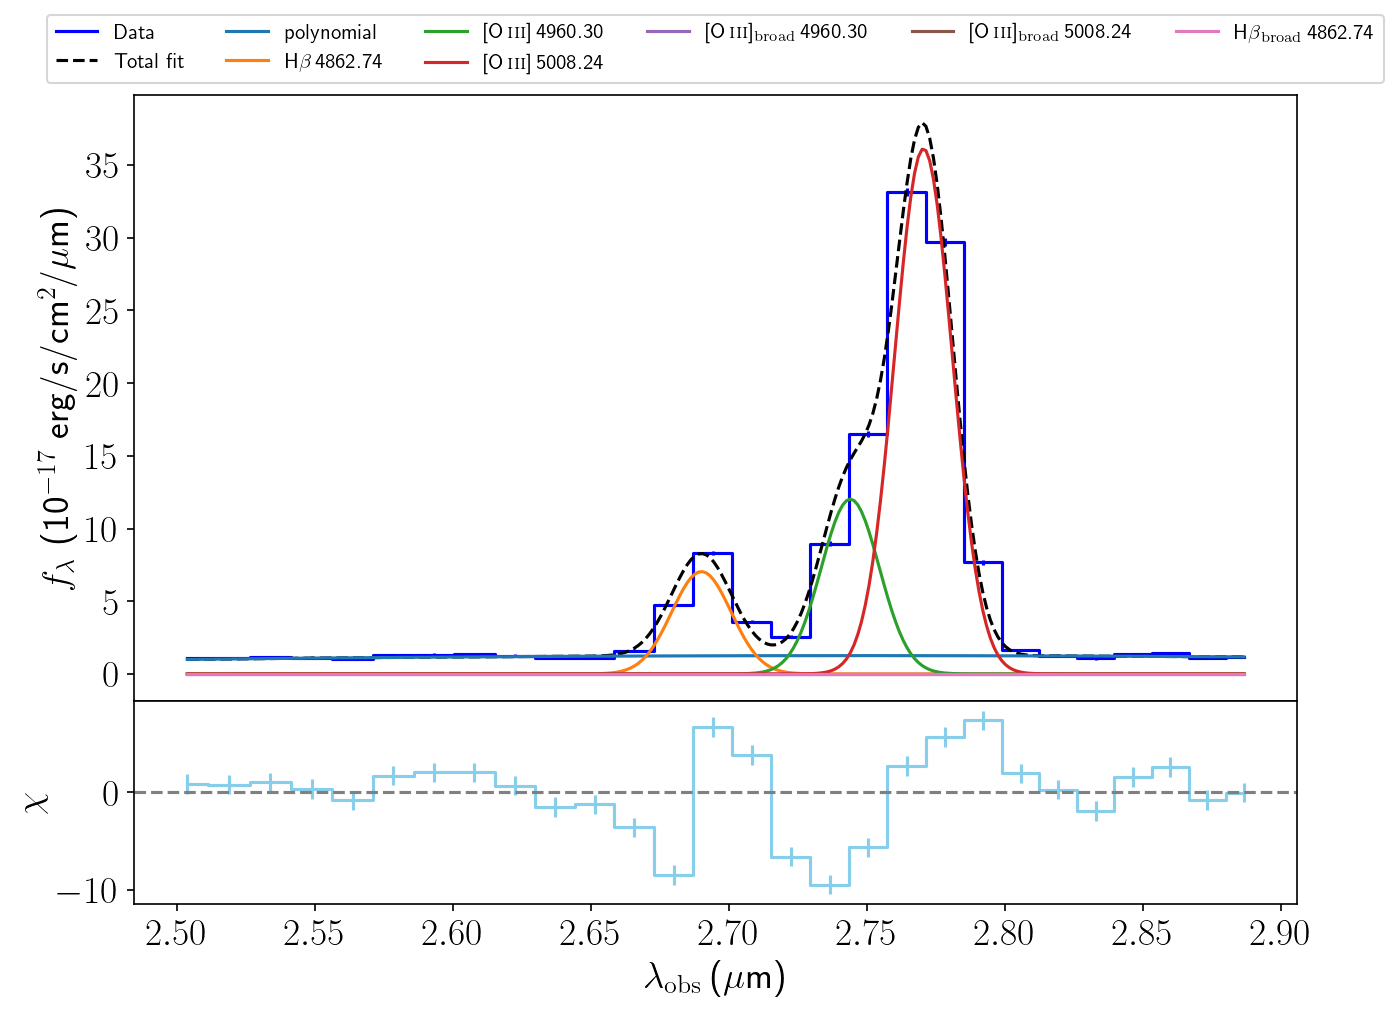

In [163]:
testo = fit_spectrum(wobs_range=(2.5,2.9), scale_disp=1.3,
                    wid_narrow = 700, min_wid_narrow=100, max_wid_narrow=10000,
                    wid_broad = 4317, min_wid_broad=4005, max_wid_broad=4641,
                    broad_lines=['OIIIw4959','OIIIw5007','Hb'], cont_model='polynomial',
                    scale_errors=False, verbose=False, save=True)

In [164]:
testo.result

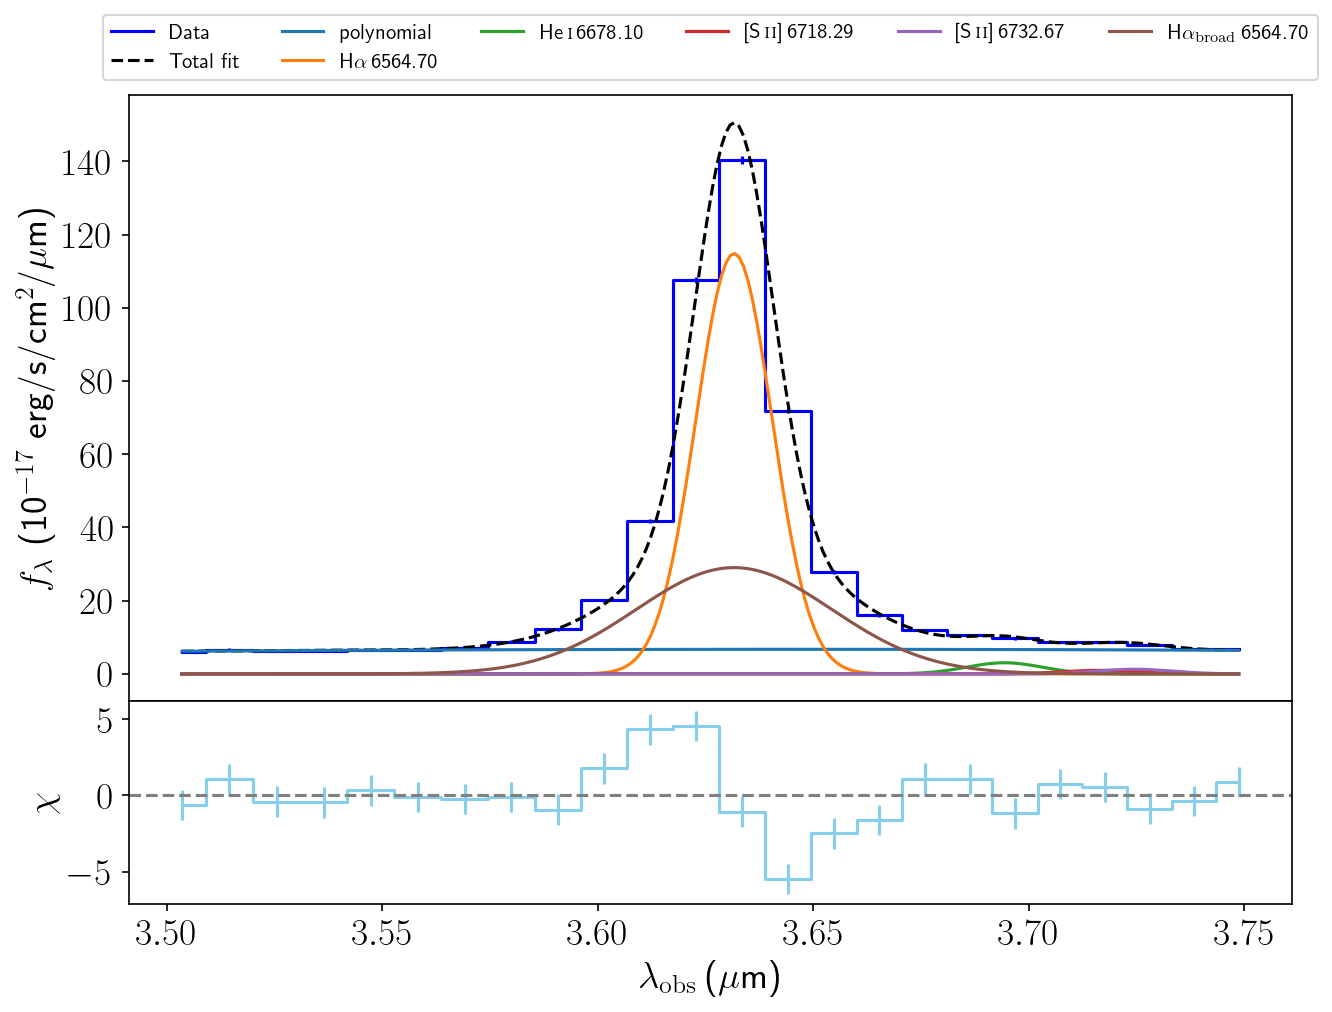

In [235]:
# Try a different fit
testy = fit_spectrum(wobs_range=(3.5,3.75), scale_disp=1.3,
                    wid_narrow = 700, min_wid_narrow=100, max_wid_narrow=10000,
                    wid_broad = 4300, min_wid_broad=1000, max_wid_broad=10000,
                    broad_lines=['Ha'], cont_model='polynomial',
                    scale_errors=False, verbose=False, save=True)

In [236]:
# testy.result
print(testy.result.fit_report())

[[Model]]
    (Model(polynomial) + ((((Model(msa_integ_gauss, prefix='Ha_') + Model(msa_integ_gauss, prefix='HeIw6678_')) + Model(msa_integ_gauss, prefix='SIIw6717_')) + Model(msa_integ_gauss, prefix='SIIw6731_')) + Model(msa_integ_gauss, prefix='Habroad_')))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 24
    # variables        = 10
    chi-square         = 91.9986877
    reduced chi-square = 6.57133483
    Akaike info crit   = 52.2492916
    Bayesian info crit = 64.0298299
    R-squared          = 0.99666191
##  Warning: uncertainties could not be estimated:
    Ha_mean:        at initial value
[[Variables]]
    c0:            -345.519067 (init = -649.8893)
    c1:             193.249779 (init = 350.421)
    c2:            -26.5059925 (init = -46.5918)
    Ha_amp:         2.54365741 (init = 2.4)
    Ha_mean:        3.63159038 (init = 3.63159)
    Ha_vw:          712.210547 (init = 700)
    HeIw6678_amp:   0.06655464 (init = 

In [251]:
znarrow = 1e4*2.69000217/4862.738 - 1
zbroad = 1e4*2.69327461/4862.738 - 1
zo4broad = 1e4*2.75345975/4960.295 - 1
zo5broad = 1e4*2.78007347/5008.239 - 1
znarrow, zbroad, zo4broad, zo5broad

(4.531867375951573, 4.538597000290783, 4.550999990927959, 4.551000002196381)

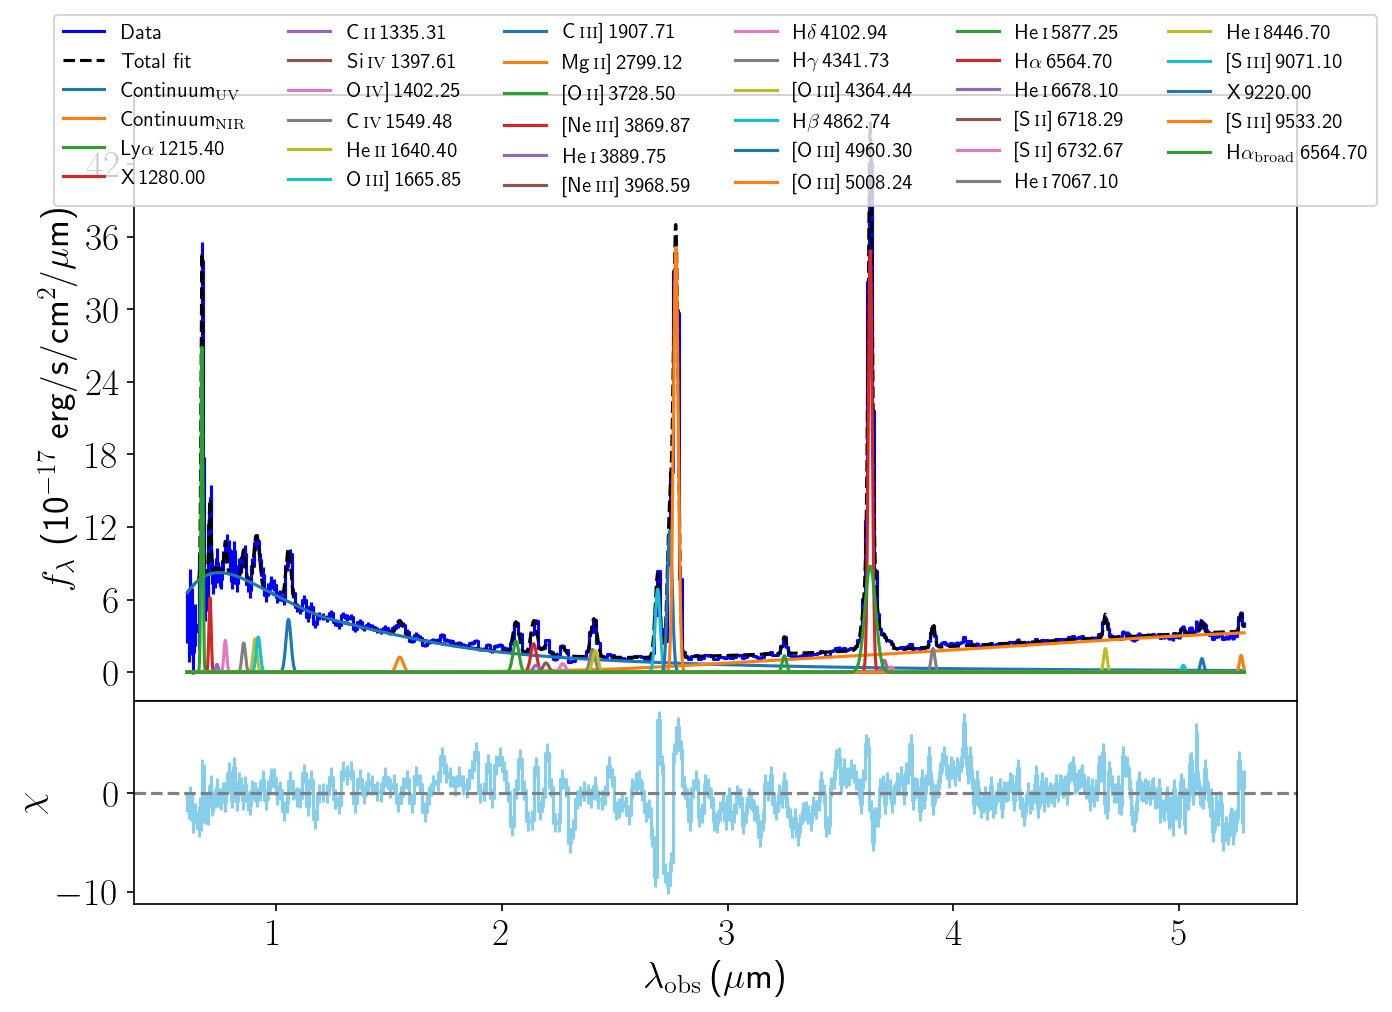

In [127]:
fitA = dill.load(open('emcee_output/AGN_smc_smc_Ha_0.5_5.5_0_self','rb'))

# MCMC

In [238]:
def emcee_uncert(testself, nwalkers=200, steps=5000, burn=500, thin=1, save=False):
# Run an emcee chain on the fit result to get correct uncertainties
    res = testself.result
    
    emcee_kws = dict(steps=steps, nwalkers=nwalkers, burn=burn, thin=thin, is_weighted=True, progress=True)
    emcee_params = res.params.copy()
    emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2)) #"set some sensible priors on uncertainty to keep mcmc in check"
    
#     def objective(params, x, data, err):
#         mod = testself.model.eval(params=params, x=x)
#         return(mod-data)/err

#     with Pool() as pool: #Doesn't work; can't pickle error; stupid lmfit
#         result_emcee = lmfit.minimize(objective, args=(np.array(testself.wrange).astype(float),
#                                             np.array(testself.frange).astype(float),
#                                             np.array(testself.erange).astype(float)),
#                                       method='emcee',
#                                       steps=steps, nwalkers=nwalkers, burn=burn, thin=thin,
#                                       is_weighted=True, progress=True,
#                                       params=emcee_params,
#                                       workers=4)
    
    result_emcee = testself.model.fit(data=testself.frange, x=testself.wrange, weights=1/testself.erange,
                                      params=emcee_params,
                                      method='emcee', nan_policy='omit', fit_kws=emcee_kws)        
    # use the output from the lmfit fit
    if save:
        file = open(f'emcee_output/{testself.save}_emcee_{nwalkers}_{steps}_{burn}_{thin}','wb')
        dill.dump(result_emcee, file)
        file.close()

    return(result_emcee)

In [166]:
#number of free parameters in the model - nwalkers has to be at least 2x this
len([elem for elem in testo.result.params if testo.result.params[elem].expr is None])

10

In [167]:
emcee_result = emcee_uncert(testo, nwalkers=100, steps=10000, burn=100, thin=1, save=True)

100%|█████████████████████████████████████| 10000/10000 [06:37<00:00, 25.17it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 10 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [370.74406083 370.61994547 370.25795079 258.63019908 267.55128907
 255.89050233 197.55725356 812.92471914 259.27940458 998.07334047
 256.57861819]


In [168]:
emcee_result.flatchain

,c0,c1,c2,Hb_amp,Hb_vw,OIIIw4959_amp,OIIIw4959_mean,OIIIw4959broad_amp,OIIIw4959broad_vw,Hbbroad_amp,__lnsigma
0,-31.947467,24.173089,-4.402783,0.194751,101.344089,0.317396,2.745350,5.169972e-10,4056.048906,9.299551e-12,-2.278453
1,-31.023037,23.613956,-4.325439,0.196562,100.743920,0.322311,2.745315,5.246323e-10,4023.804730,9.485286e-12,-2.244179
2,-31.870545,24.225764,-4.428471,0.189305,100.184353,0.320763,2.745361,5.085523e-10,4005.898893,9.236433e-12,-2.270642
3,-32.006199,24.298296,-4.433580,0.190306,100.398607,0.317419,2.745324,5.135742e-10,4007.110854,9.201463e-12,-2.304738
4,-30.743813,23.749407,-4.408580,0.197300,101.051164,0.317762,2.745293,4.933915e-10,4024.820471,9.299414e-12,-2.314894
...,...,...,...,...,...,...,...,...,...,...,...
989995,18.072472,-12.849768,2.427817,0.195926,166.873573,0.319541,2.745391,3.551914e-03,4069.973263,6.813933e-03,-1.241227
989996,19.426947,-13.667335,2.547719,0.195112,170.501630,0.324182,2.745193,4.371133e-04,4367.732962,9.334201e-03,-4.280291
989997,2.532355,-1.351936,0.307894,0.198861,170.717829,0.320920,2.745330,1.700493e-03,4332.972155,5.020004e-04,-4.179725
989998,19.322624,-13.746169,2.592478,0.199956,113.621749,0.324623,2.745305,5.893631e-04,4484.035915,3.255691e-04,-5.002304


In [169]:
# fitA_emcee = dill.load(open('emcee_output/AGN_smc_smc_Ha_0.5_5.5_0_emcee_100_10000_100_1','rb'))

In [210]:
req_cols = emcee_result.flatchain.columns[3:-1]
# req_cols = ['Hb_amp','OIIIw4959_amp','OIIIw4959broad_amp','Hbbroad_amp']
req_cols = ['Ha_amp', 'Ha_vw','Habroad_amp','Habroad_vw']
req_cols

['Ha_amp', 'Ha_vw', 'Habroad_amp', 'Habroad_vw']

In [211]:
# Names for MCMC corner plot - very hacky, but works for now
lbs = Table.read('lines_list.txt', format='ascii')
cnames = {'l_A_v':r'A$_{V,UV}$', 'l_beta':r'$\beta_{UV}$', 'l_norm':r'norm$_{UV}', 'r_A_v':r'A$_{V,NIR}$', 'r_beta':r'$\beta_{NIR}$', 'r_norm':r'norm$_{NIR}', 'r_temp':'T$_b$', '__lnsigma':'MCMC ln($\sigma$)'}
corner_names = []
title_names = []
for pname in req_cols:
    lname, param, *_ = pname.split('_')
#     if param == 'ht':
#         param = 'height'
    if param == 'amp':
        param = 'amplitude'
    elif param == 'vw':
        param = 'width'
    else:
        param = 'value'
    if 'broad' in lname:
        brd = '\,broad'
        lname = lname.replace('broad','')
    else:
        brd = ''
    if lname not in lbs['line']:
        corner_names.append(cnames[pname])
    else:
        wav = lbs['wavelength(A)'][list(lbs['line']).index(lname)]
        lb = lbs['label'][list(lbs['line']).index(lname)]
        if brd != '':
            corner_names.append(fr'{lb}$_\mathrm{{{brd}}}$ {param}')
        else:
            corner_names.append(fr'{lb} {param}')
    title_names.append(param)

corner_names, title_names

(['H$\\alpha$ amplitude',
  'H$\\alpha$ width',
  'H$\\alpha$$_\\mathrm{\\,broad}$ amplitude',
  'H$\\alpha$$_\\mathrm{\\,broad}$ width'],
 ['amplitude', 'width', 'amplitude', 'width'])

In [212]:
emcee_result.flatchain

,c0,c1,c2,Hb_amp,Hb_vw,OIIIw4959_amp,OIIIw4959_mean,OIIIw4959broad_amp,OIIIw4959broad_vw,Hbbroad_amp,__lnsigma
0,-31.947467,24.173089,-4.402783,0.194751,101.344089,0.317396,2.745350,5.169972e-10,4056.048906,9.299551e-12,-2.278453
1,-31.023037,23.613956,-4.325439,0.196562,100.743920,0.322311,2.745315,5.246323e-10,4023.804730,9.485286e-12,-2.244179
2,-31.870545,24.225764,-4.428471,0.189305,100.184353,0.320763,2.745361,5.085523e-10,4005.898893,9.236433e-12,-2.270642
3,-32.006199,24.298296,-4.433580,0.190306,100.398607,0.317419,2.745324,5.135742e-10,4007.110854,9.201463e-12,-2.304738
4,-30.743813,23.749407,-4.408580,0.197300,101.051164,0.317762,2.745293,4.933915e-10,4024.820471,9.299414e-12,-2.314894
...,...,...,...,...,...,...,...,...,...,...,...
989995,18.072472,-12.849768,2.427817,0.195926,166.873573,0.319541,2.745391,3.551914e-03,4069.973263,6.813933e-03,-1.241227
989996,19.426947,-13.667335,2.547719,0.195112,170.501630,0.324182,2.745193,4.371133e-04,4367.732962,9.334201e-03,-4.280291
989997,2.532355,-1.351936,0.307894,0.198861,170.717829,0.320920,2.745330,1.700493e-03,4332.972155,5.020004e-04,-4.179725
989998,19.322624,-13.746169,2.592478,0.199956,113.621749,0.324623,2.745305,5.893631e-04,4484.035915,3.255691e-04,-5.002304


In [213]:
# Make a corner plot of MCMC result
def plot_corner(testself, emcee_res, req_params=None, title_names=None,
                quants=[0.16, 0.5, 0.84], save=False):
    
    dataframe = emcee_res.flatchain[-len(emcee_res.flatchain):]
    dataframe = dataframe[req_params]
    fs = 28
    
    for col in dataframe.columns:
        if 'amp' in col:
            print(col)
            dataframe[col] = dataframe[col]*100 #multiply amplitude by 100 to get 2 digit precision on plot

    figure = corner.corner(dataframe, labels=corner_names, quantiles=quants, show_titles=True, titles=title_names, 
#                            truths=[emcee_res.params.valuesdict().get(key) for key in req_params], truth_color='deepskyblue',
                           label_kwargs={'fontsize':fs}, title_kwargs={'fontsize':fs}, labelpad=-0.001)
    
    values = np.array([corner.quantile(elem,0.5) for elem in np.array(dataframe).T]).reshape(len(req_params))
    corner.overplot_lines(figure, values, color='deepskyblue', linewidth=3)
    corner.overplot_points(figure, values[None], marker='o', color='deepskyblue', markersize=10)

    figure.subplots_adjust(right=1.5,top=1.5)
    for ax in figure.get_axes():
        ax.tick_params(axis='both', labelsize=fs)

    if save:
        nstep, nwalk, burn, thin = list(emcee_res.kws.values())[:-2]
        figure.savefig(f'emcee_output/{testself.save}_corner_{nwalk}_{nstep}_{burn}_{thin}.pdf',
                       format='pdf', dpi=50, pad_inches=0, bbox_inches='tight')
    
#     figure.close() #not sure if this is the correct way

Ha_amp
Habroad_amp


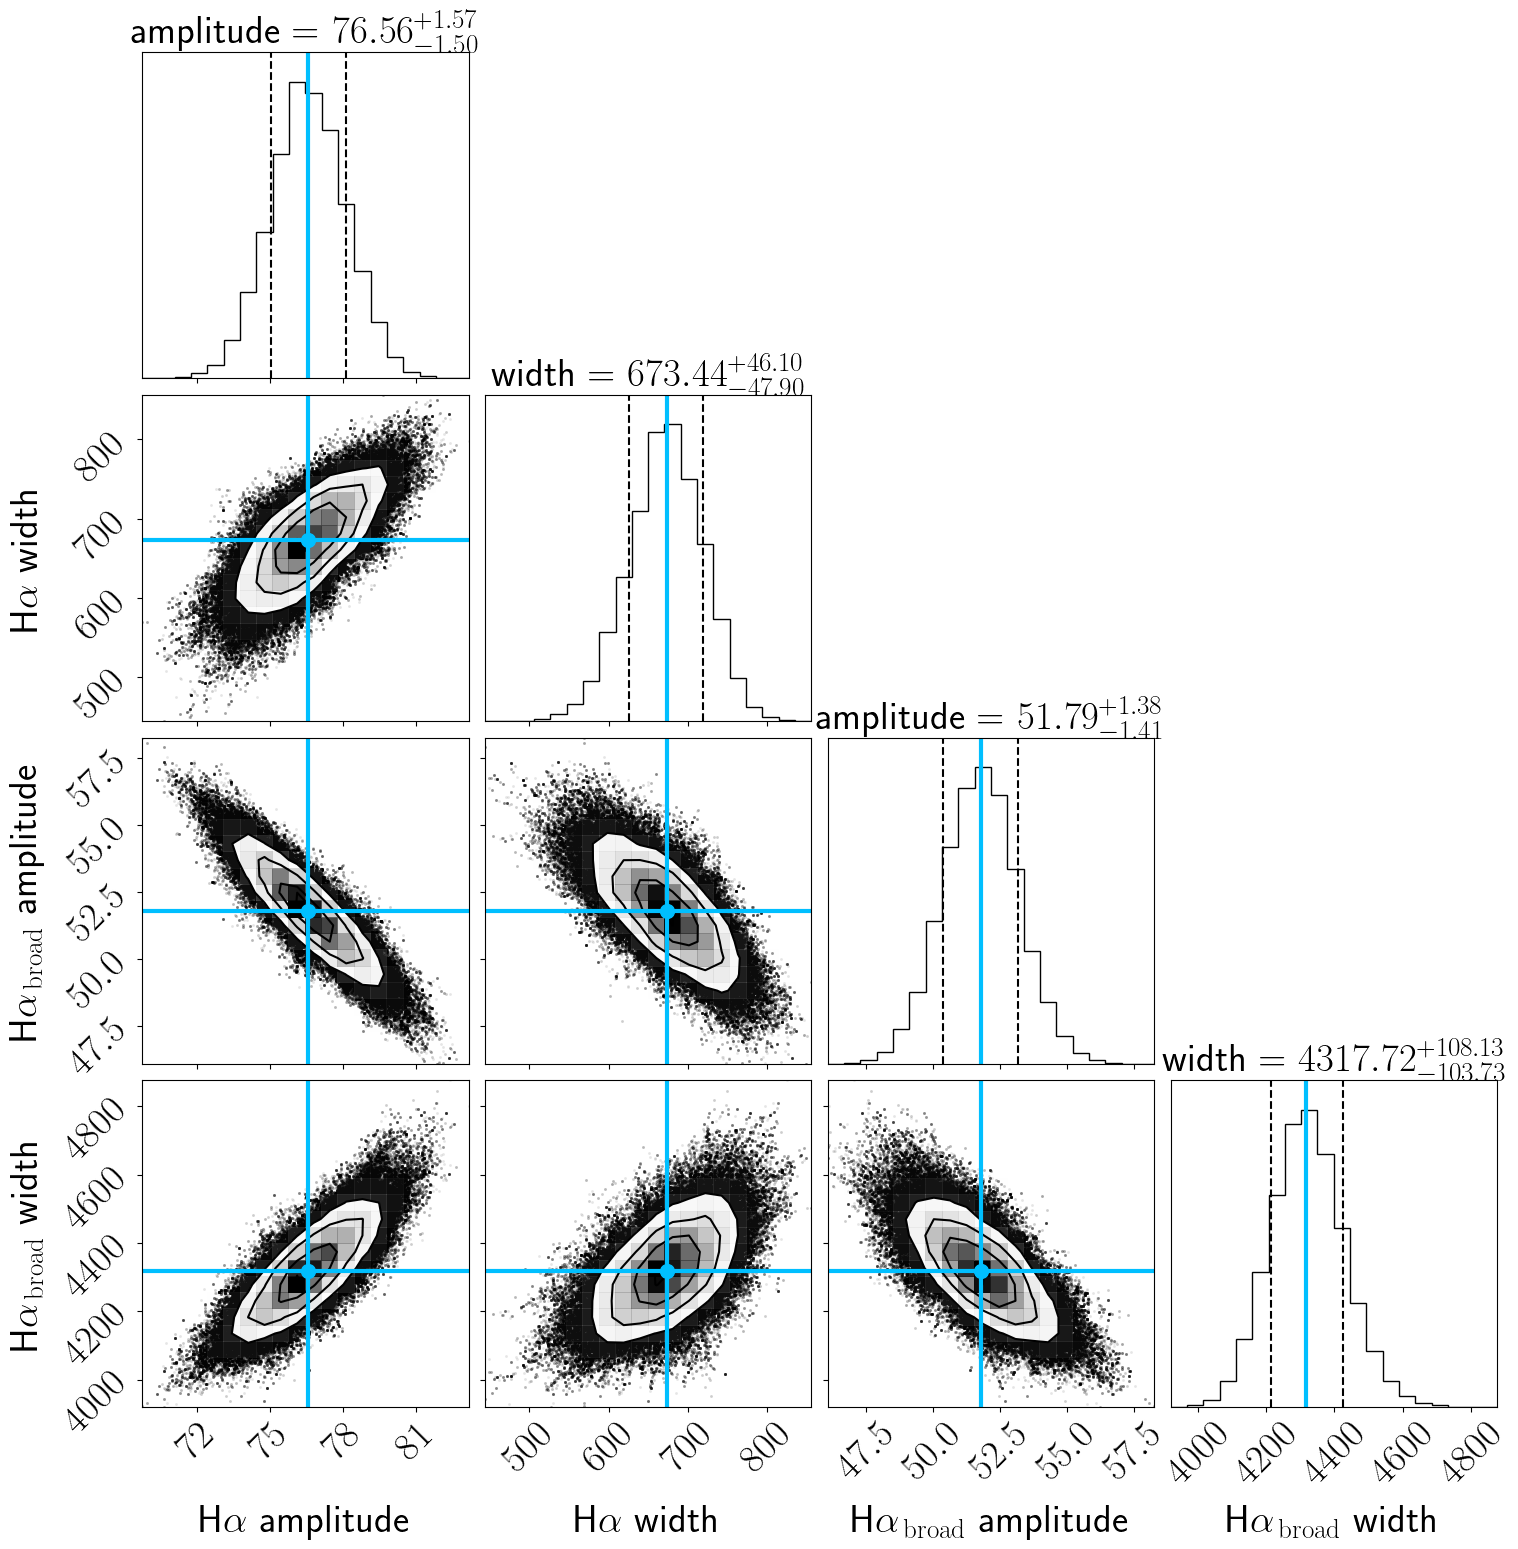

In [214]:
plot_corner(fitA, fitA_emcee, req_params=req_cols, save=True, title_names=title_names)

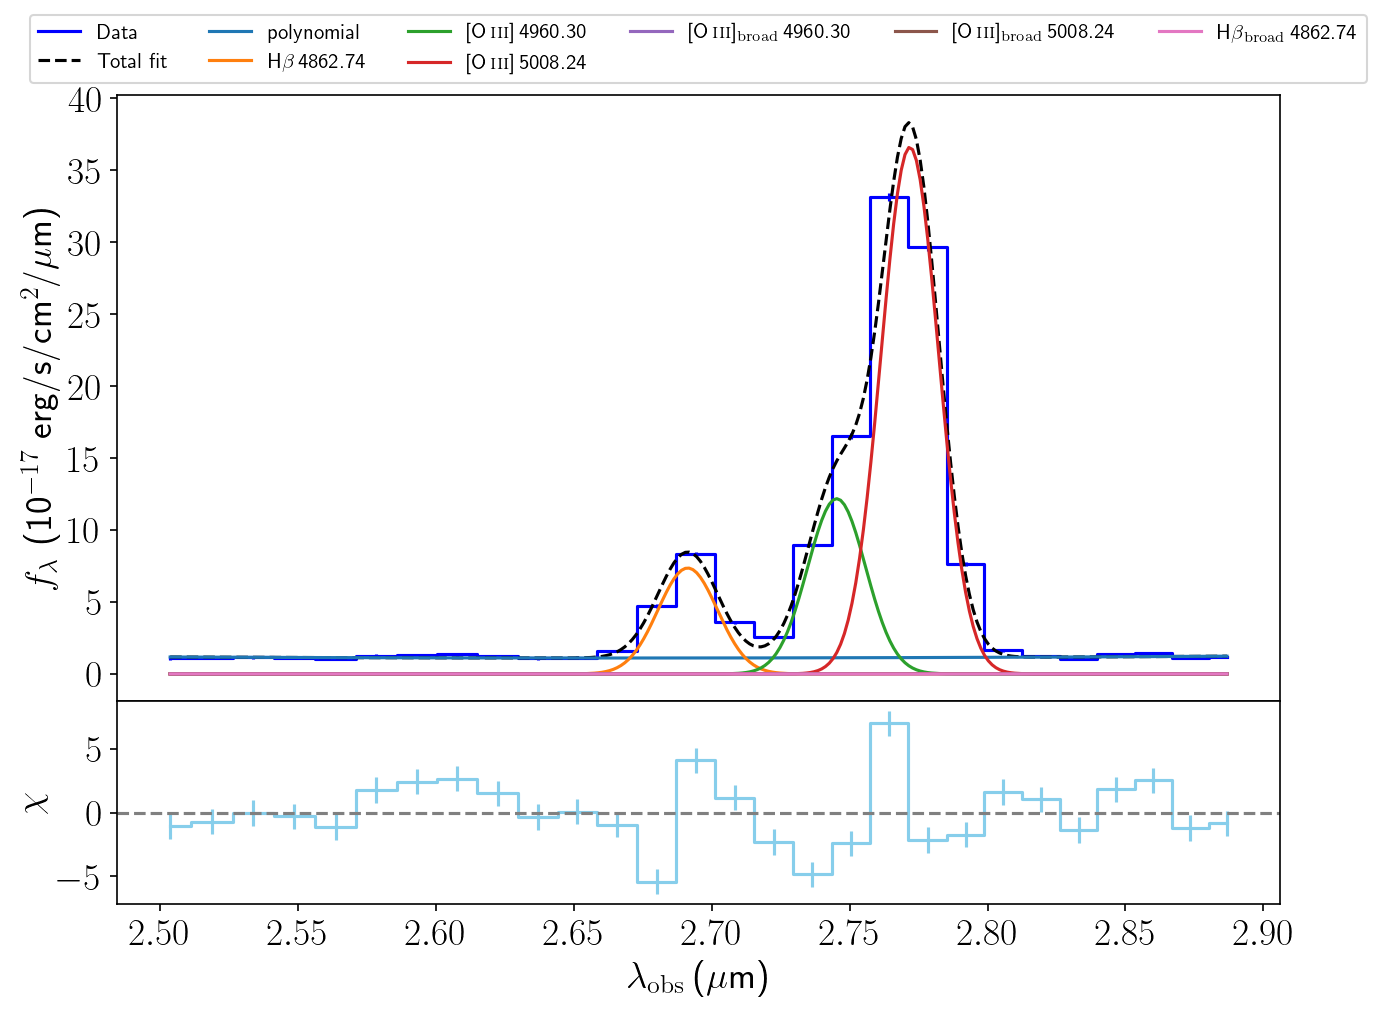

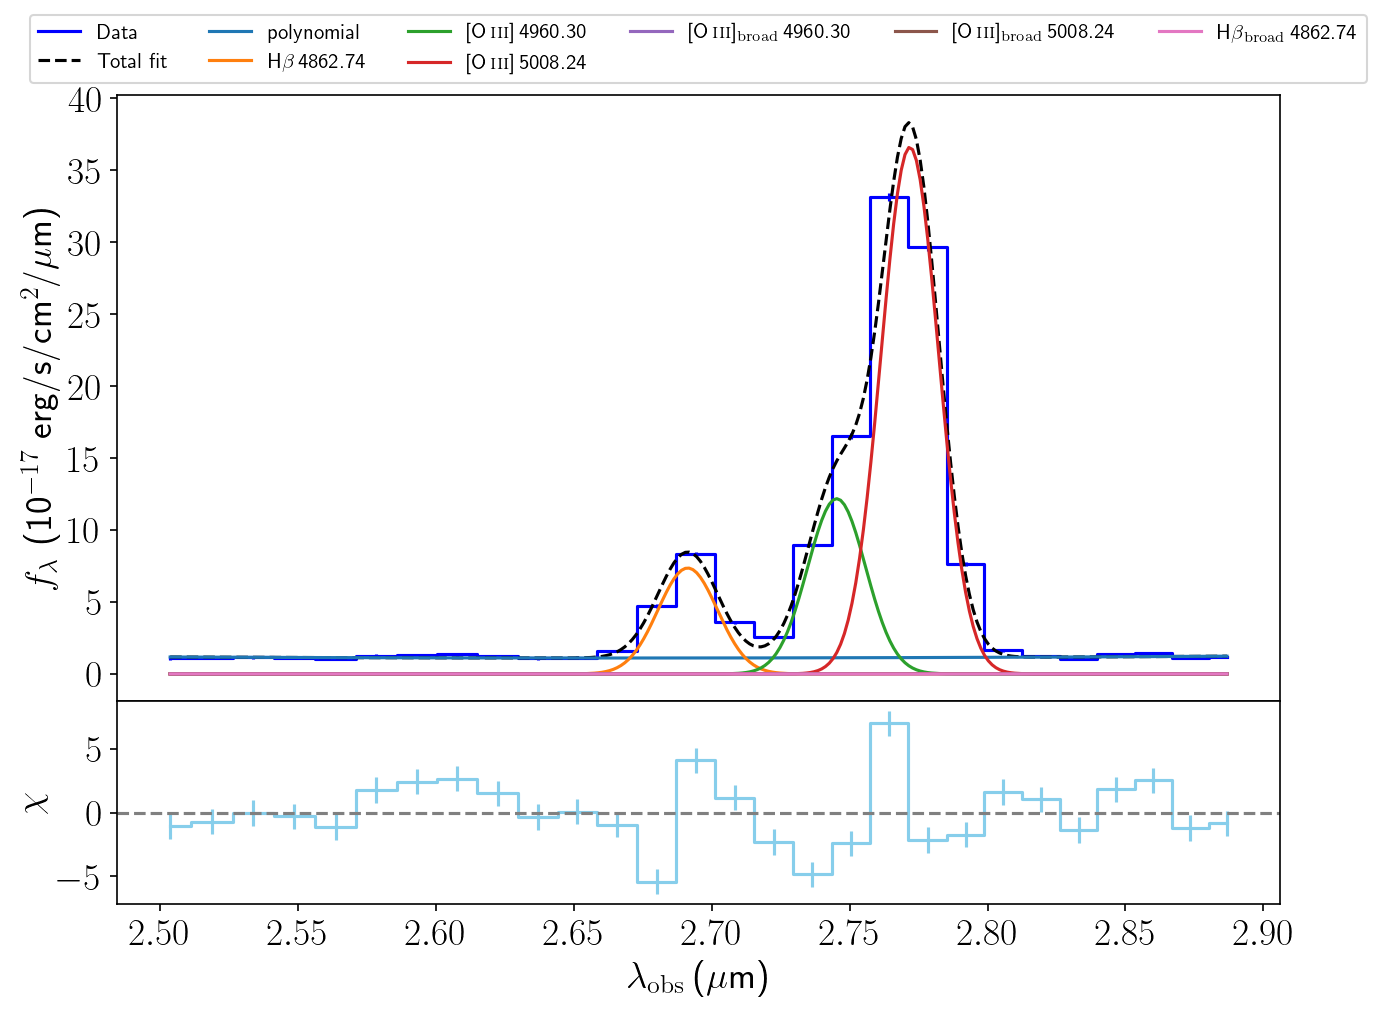

In [179]:
testo.plot_fit_spec(emcee_result)

# Discarded

In [ ]:
#Simone's code

import emcee
import os, sys
from multiprocessing import Pool

# Define the likelihood
def lnlike(theta, x, y, yerr, func):
    model = func(theta, x)
    sigma2 = yerr ** 2
    LnLike = -0.5 * np.sum((y - model) ** 2 / sigma2)
    return LnLike

# Define the probability function
def lnprob(theta, x, y, yerr, func, prior):
    lp = prior(theta)
    if not lp == 0: #check if lp is infinite
        return -np.inf
    return lp + lnlike(theta, x, y, yerr, func)

def runmcmc(p0, nwalkers, niter, ndim, nburn, lnprob, data, func, pool):#prior,
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[*data,func], pool=pool)#,prior]

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, nburn, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state
    
def fitting(testself, nwalkers, niter, nburn, save=True):
    # Defining initial conditions for fitting
    data = (testself.wrange, testself.frange, testself.erange)
    initial = testself.result.params
    ndim = len(initial) # This should be the number of parameters
    p0 = [np.array(initial) + 0.5 * np.random.randn(ndim)]

    with Pool() as pool: # Multithreading using the multiprocessing module
        sampler, pos, prob, state = runmcmc(p0, nwalkers, niter, ndim, nburn, lnprob, data, fit_func, pool)#prior

    if save:
        np.savetxt(main_path + f'emcee_output/{testself.name}_samples.txt', samples)
    print('Results: ')

    return sampler

res = fitting(nwalkers=1000, niter=100, nburn=100)

In [ ]:
from lmfit import Minimizer, fit_report

def objective(params, x, data):
    mod = spec.model.eval(params=params, x=x)
#     disp = spec.prism_res_tab
#     resolution = np.interp(spec.wrange, disp['WAVELENGTH'], disp['R'], left=disp['R'][0], right=disp['R'][-1])
#     vw = 700 #should be something from params
#     resamp_mod = resample_template_numba(np.array(spec.wrange).astype(float), x, mod, nsig=5)
    return(mod-data)

result = lmfit.minimize(objective, spec.params, args=(np.array(spec.wrange).astype(float), np.array(spec.frange).astype(float)), method='nelder')

In [ ]:
#Gabe's msaexp resample - does not work for continuum; only line

from msaexp.resample_numba import resample_template_numba as resample_func
# from msaexp.resample import resample_template as resample_func
# mod1 = GaussianModel(prefix='l_')
# ps1 = mod1.make_params()
# mod2 = GaussianModel(prefix='c_')
# ps2 = mod2.make_params()
# mod = mod1+mod2
# ps = ps1+ps2
xarr = np.linspace(0.5,5,100)
init = spec.model.eval(params=spec.params, x=xarr)
disp = spec.prism_res_tab
resolution = np.interp(spec.wrange, disp['WAVELENGTH'], disp['R'], left=disp['R'][0], right=disp['R'][-1])
resamp = resample_func(np.array(spec.wrange).astype(float), np.array(resolution).astype(float)*spec.scale_disp, xarr, init, velocity_sigma=700/2.355, nsig=5)

In [ ]:
spec = model_spectrum(wobs_range=(1.8,4.2), scale_disp=1.3, wid_broad = 4500, broad_lines=['Ha'], cont_model='polynomial')
res = np.interp(spec.wrange, spec.prism_res_tab['WAVELENGTH'], spec.prism_res_tab['R'],left=spec.prism_res_tab['R'][0], right=spec.prism_res_tab['R'][-1])
line1 = line_func(spec.wrange.astype(float), res.astype(float)*1.3, 3, line_flux=140*np.sqrt(2*np.pi)*900*3/(c*2.355), velocity_sigma=900)
line2 = line_func(spec.wrange.astype(float), res.astype(float)*1.3, 3, line_flux=60*np.sqrt(2*np.pi)*4300*3/(c*2.355), velocity_sigma=4300)
plt.plot(spec.wrange, line1)
plt.plot(spec.wrange, line2)
plt.plot(spec.wrange, line1+line2)

#okay wait, so this is the line model with a coarse sampling? so this is what lmfit gets to fit to the data?
#oh line_flux is apparently the normalisation of the line, so i guess it's the "amplitude" in the lmfit Gaussian?!
# So that's h = A/(sqrt(2pi)*sigma) => A = h*sqrt(2pi)*sigma
# should this be the observed sigma, ie resolution convolved like in my lw_sig_um function?
# Or just sigma from fwhm without convolving resolution??
# oh wait! should the flux be preserved?! Resolution convolved sigma*observed height == unconvolved sigma* intrinsic height?! I think so!
# so i should let lmfit fit for it; instead of height